## Experiment Setup

### Random seed / PyTorch / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

NumPy Version: 1.17.4
PyTorch Version: 1.4.0a0+328ec54
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
            
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Variable settings

#### Data prep

In [4]:
# Dataset to use
uci_dataset_name = 'protein-tertiary-structure'

# Set the proportion of the original dataset to be available as a whole
subset_proportions = [0.4, 0.6, 0.8, 1]

# Proportion of the dataset (after getting the subset) to be used for training
train_prop = 0.8

# Number of dataset splits
n_splits = 10

#### NN settings

In [5]:
# Fully-Connected network hidden layers
network_hidden_dims = [25, 50, 100]
network_hidden_layers = [1, 3, 5]

# Dropout
dropout_rates = [0.005, 0.01, 0.05, 0.1]

# Regularization strengths
reg_strengths = [0.025, 0.05, 0.075]

#### Training setup

In [6]:
# Number of epochs
n_epoch = 400

# Optimizer learning rate
learning_rate = 0.01

# Data batch sizes
n_training_batch = 128

# Number of test predictions (for each data point)
prediction_runs = [3, 10, 100, 1000, 3000, 5000, 7000, 10000]

# Mean Squared Error for loss function to minimize
objective = nn.MSELoss()

# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

## Train the network

In [0]:
for subset_prop, hidden_dim, n_hidden, dropout_rate, reg_strength in itertools.product(
    subset_proportions,
    network_hidden_dims, network_hidden_layers,
    dropout_rates, reg_strengths,
):

    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)

    """
    Results file storage
    """
 
    # Create directory to store results for the current test configuration
    test_results_path = os.path.join(
        './test_results',
        'number_of_test_predictions_1',
        uci_dataset_name,
        test_start_time,
        (
            str(subset_prop) 
            + '_' + str(hidden_dim) 
            + '_' + str(n_hidden) 
            + '_' + str(dropout_rate) 
            + '_' + str(reg_strength)),
    )
    
    os.makedirs(test_results_path, exist_ok=True)
    
    test_results_rmse_mc_path = os.path.join(
        test_results_path,
        "rmse_mc.txt"
    )
    
    test_results_lls_mc_path = os.path.join(
        test_results_path,
        "lls_mc.txt"
    )

    # Prepare new subset of the original dataset
    subset = datasets.UCIDatasets(
        uci_dataset_name, root_dir='./datasets_files', 
        limit_size=subset_prop, transform=None, download=True)

    # Determine sizes of training and testing set
    train_size = int(train_prop * len(subset))
    test_size = len(subset) - train_size
    
    # Print the size of the subset
    print("subset size = " + str((len(subset), subset.n_features)))
    print("training set size = %d" % train_size)
    print("test set size = %d" % test_size)
    
    train, test = random_split(subset, lengths=[train_size, test_size])

    train_loader = DataLoader(train, batch_size=n_training_batch, pin_memory=use_pin_memory)

    # Prepare network
    network = models.FCNetMCDropout(
        input_dim=subset.n_features, 
        output_dim=subset.n_targets,
        hidden_dim=hidden_dim,
        n_hidden=n_hidden,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
    )
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    
    # Model to train mode
    network.train()
    
    # Adam optimizer
    # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
    # NOTE: Need to set L2 regularization from here
    optimizer = optim.Adam(
        network.parameters(),
        lr=learning_rate,
        weight_decay=reg_strength, # L2 regularization
    )

    print()

    """
    Training
    """

    print(
        "Starting subset %f, n_hidden %d, hidden_dim %d, dropout_rate %f, reg_strength %f"
        % (subset_prop, n_hidden, hidden_dim, dropout_rate, reg_strength))

    # Record training start time (for this split)
    tic = time.time()

    for epoch in range(n_epoch): # loop over the dataset multiple times
        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            # Store the batch to torch_device's memory
            inputs = inputs.to(torch_device)
            targets = targets.to(torch_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)

            loss = objective(outputs, targets)
            loss.backward()

            optimizer.step()
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = %f" % (loss.item()))

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Get the test data
    inputs, targets = test.dataset[test.indices]

    # Store the batch to torch_device's memory
    inputs = inputs.to(torch_device)
    targets = targets.to(torch_device)

    for n_predictions in prediction_runs:
        print(str(n_predictions) + " test runs...")

        # Record testing start time (for this split)
        tic_testing = time.time()

        _, mean, var, metrics = network.predict_dist(
            inputs, n_predictions, y_test=targets, reg_strength=reg_strength)

        # Record testing end time
        toc_testing = time.time()

        # store additional metrics
        if len(metrics) > 0:

            for key, value in metrics.items():
                print(str(key) + " = " + str(value))

                if key == 'rmse_mc':
                    with open(test_results_rmse_mc_path, 'a+') as rmse_mc_file:
                        rmse_mc_file.write('%d %f \n' % (n_predictions, value))

                elif key == 'test_ll_mc':
                    with open(test_results_lls_mc_path, 'a+') as lls_mc_file:
                        lls_mc_file.write('%d %f \n' % (n_predictions, value))
            print()
            
    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    # Report the total testing time
    print("testing time (last run) = " + str(toc_testing - tic_testing) + " seconds")

    print()

## Plot the results

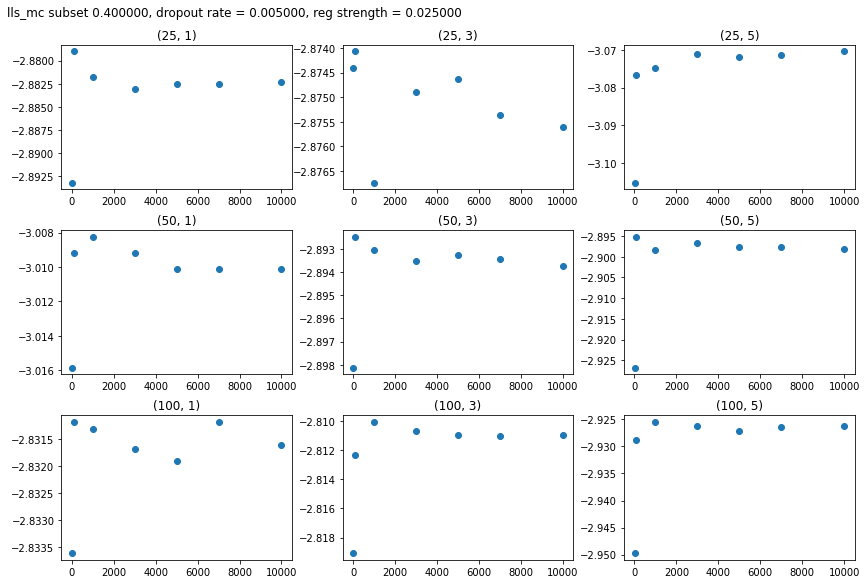

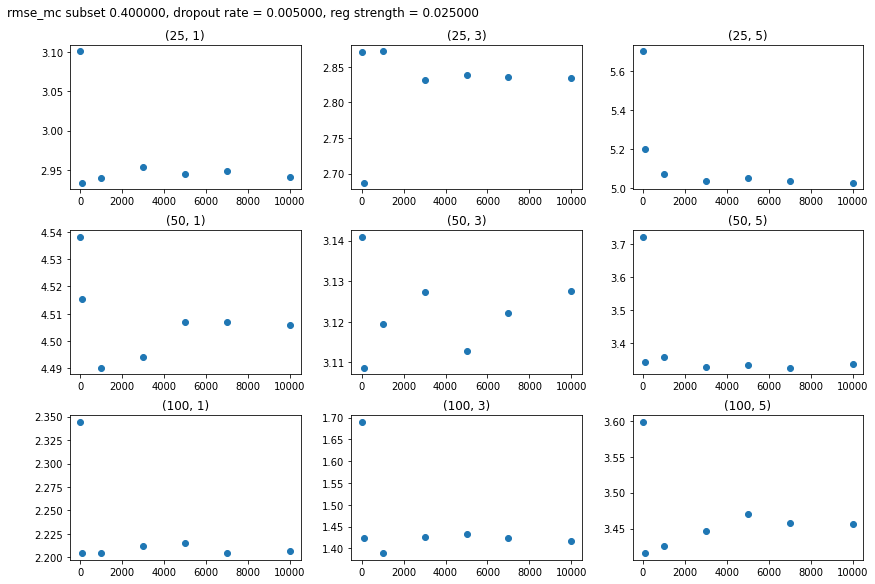

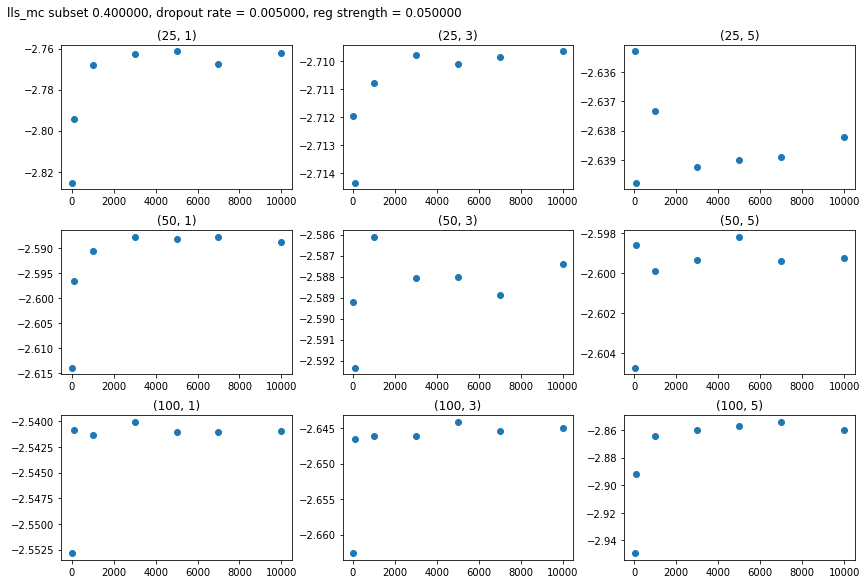

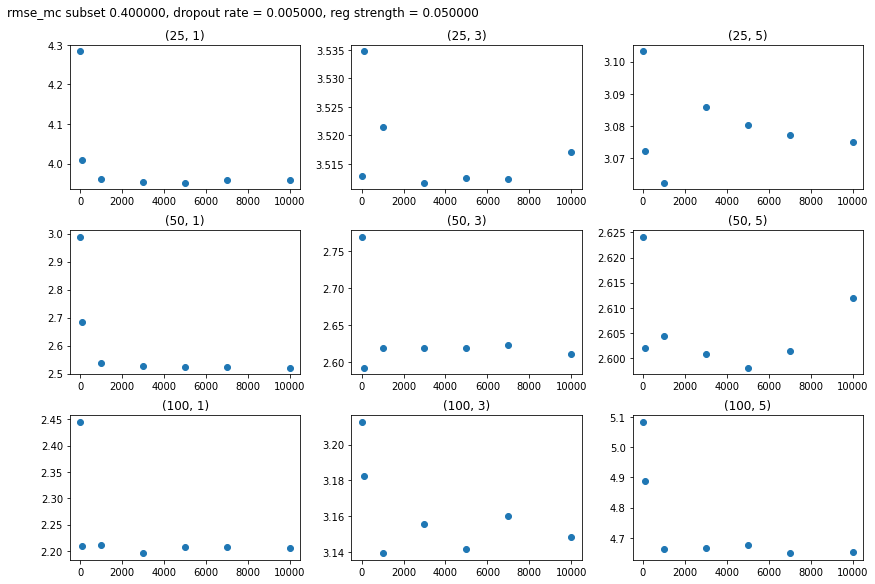

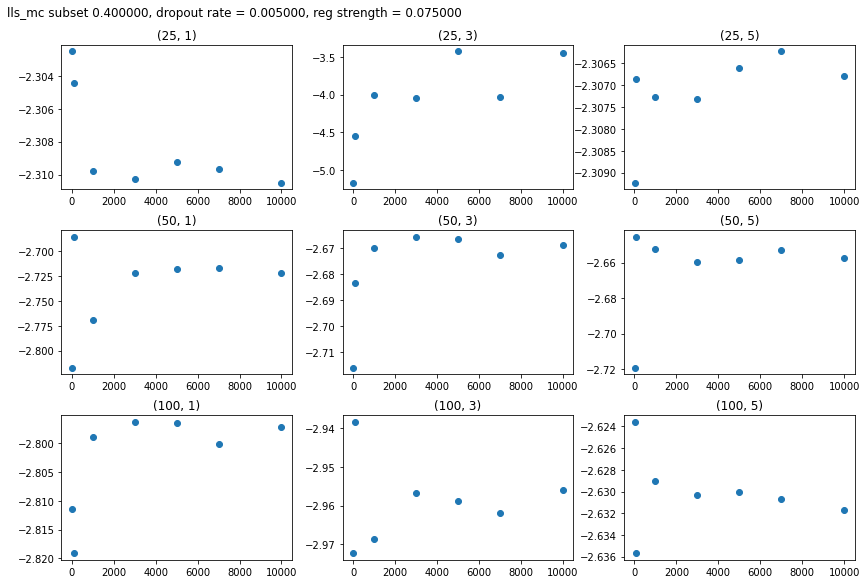

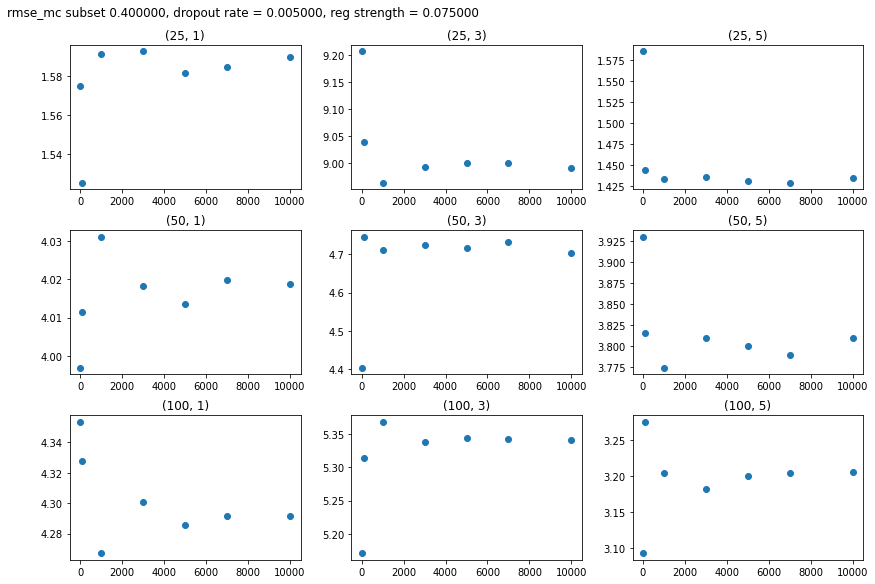

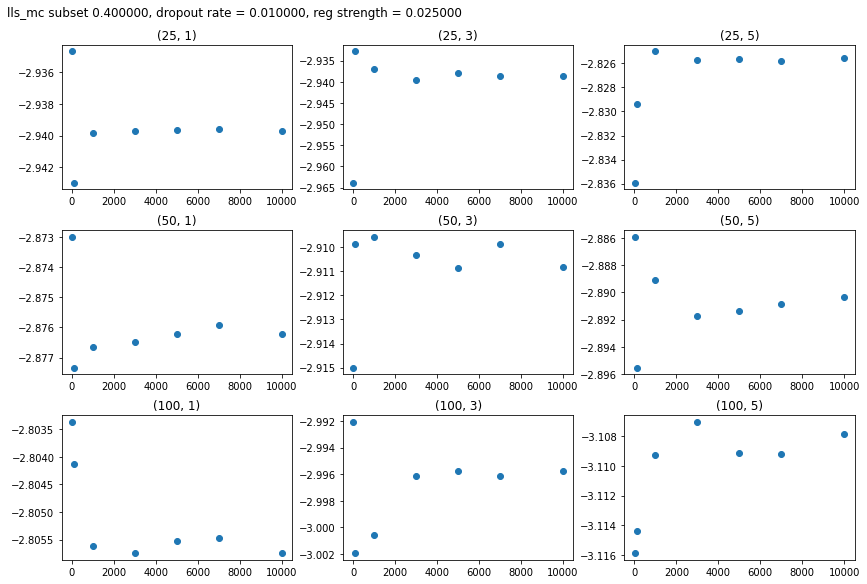

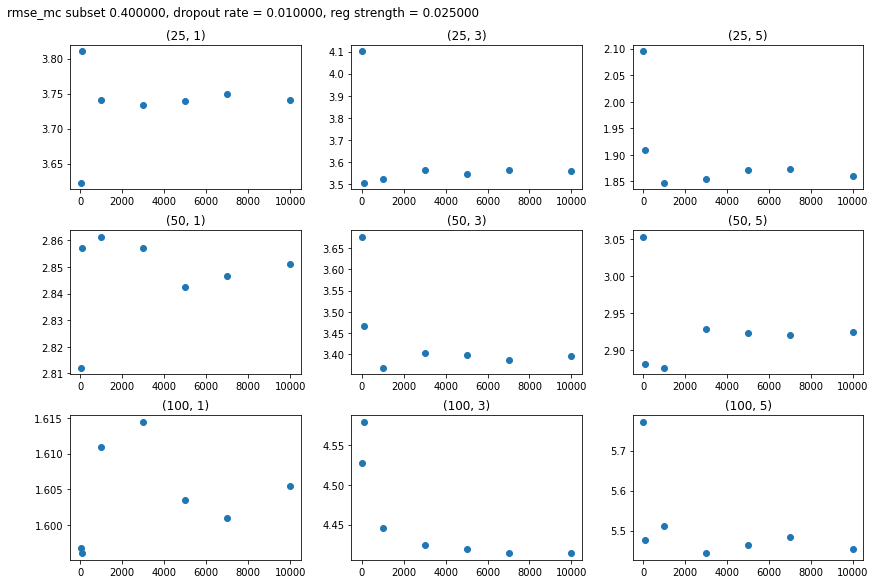

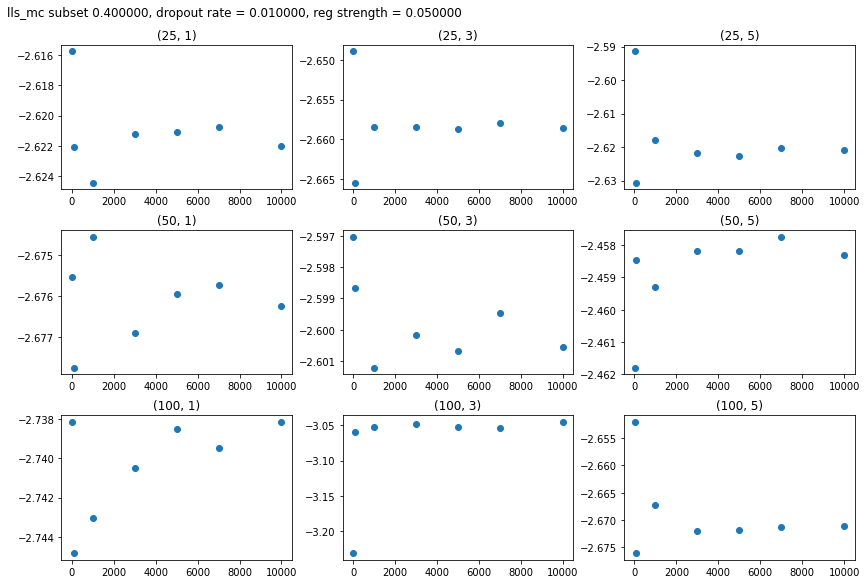

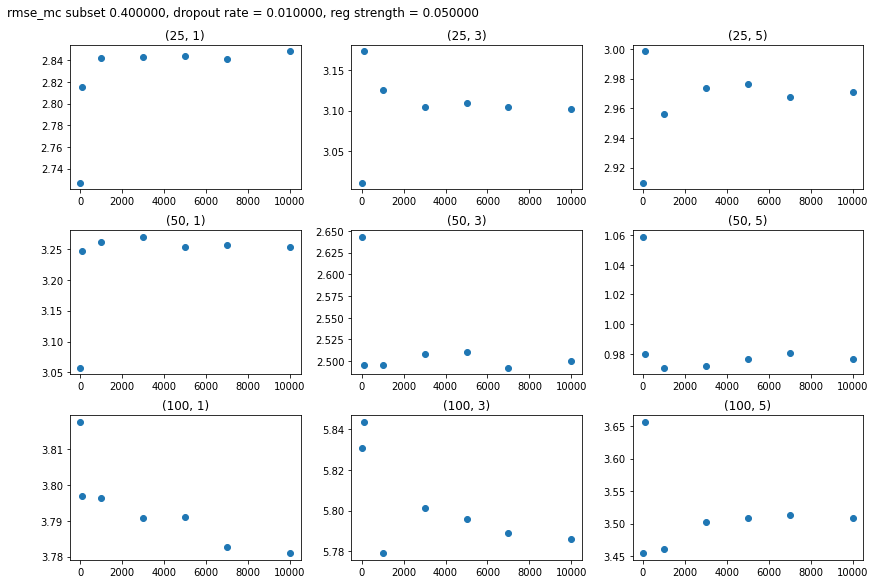

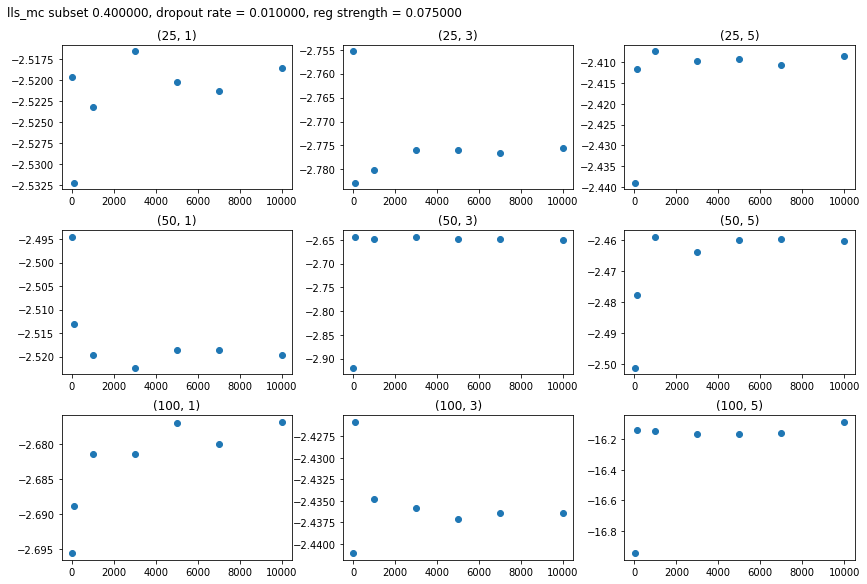

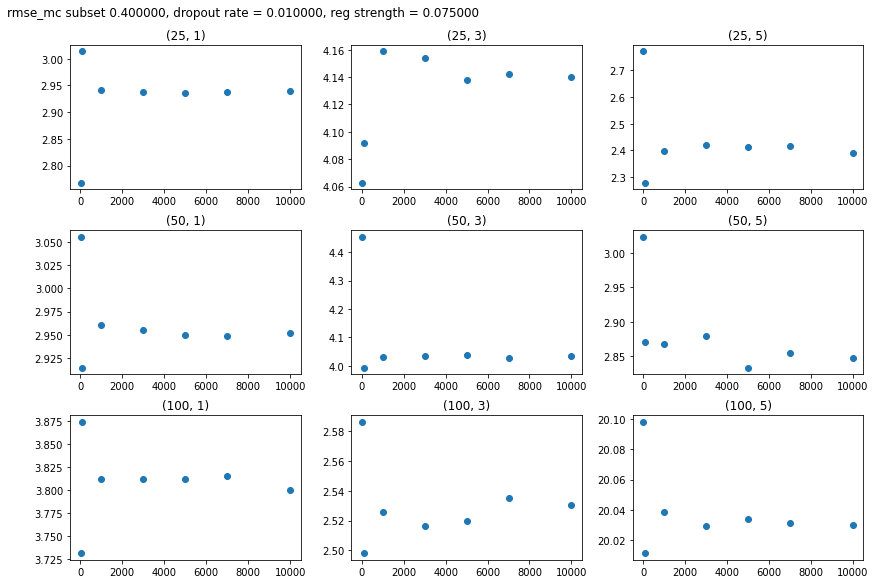

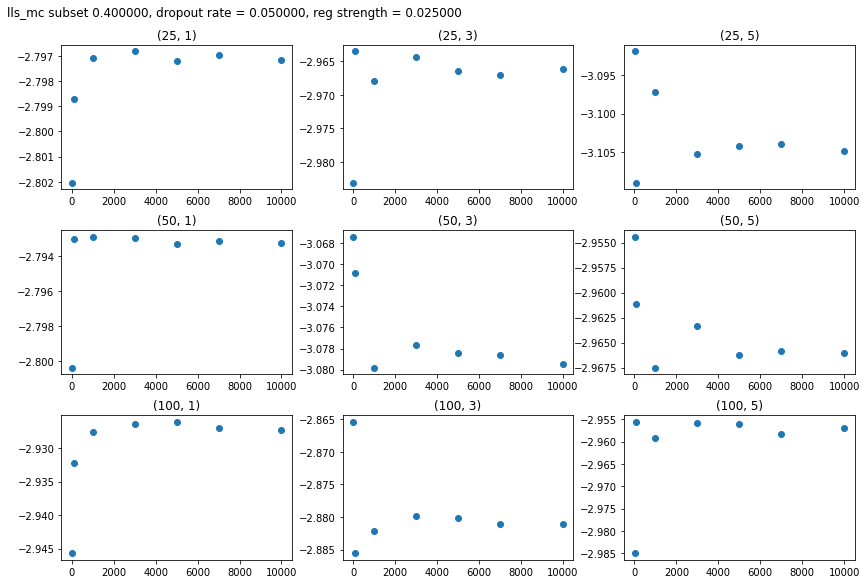

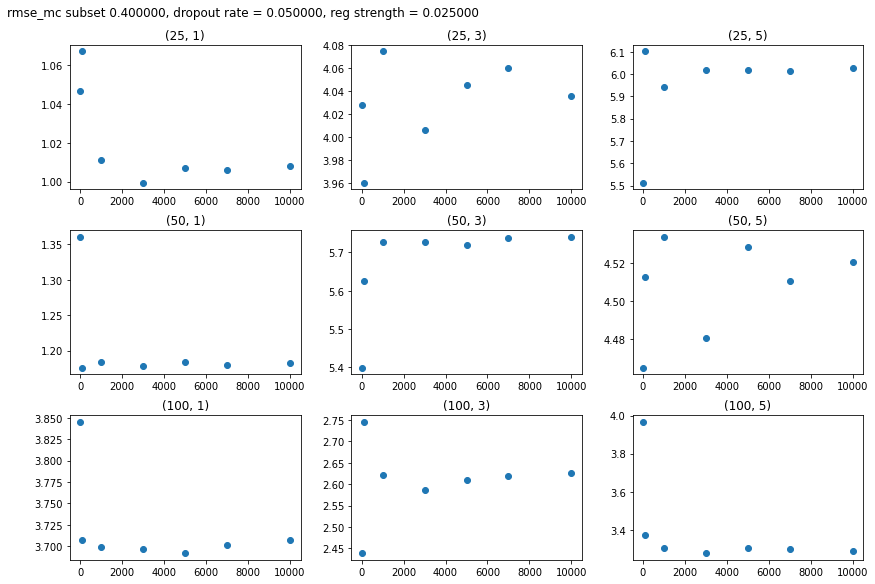

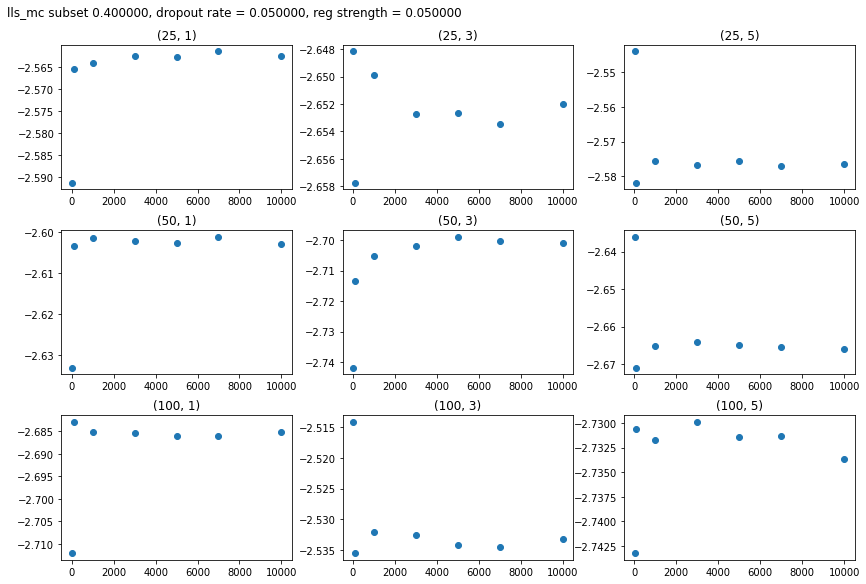

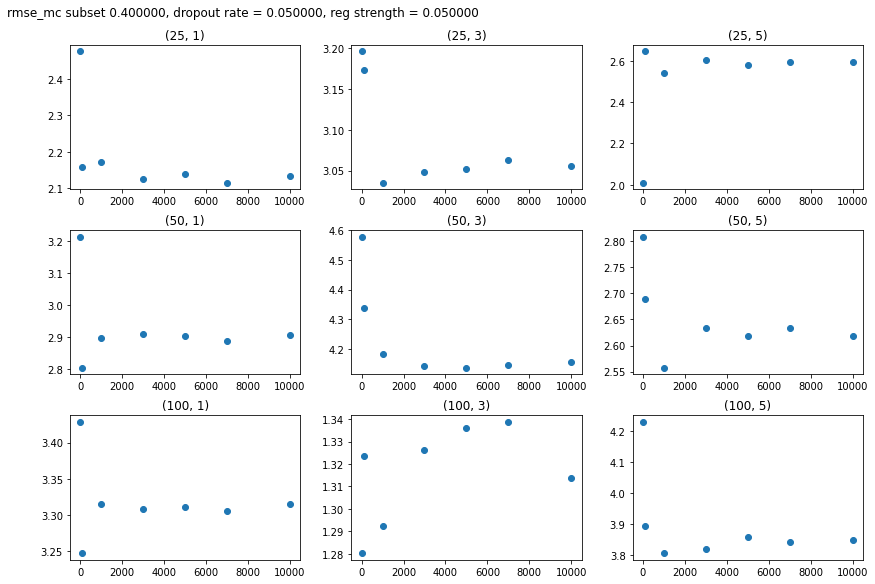

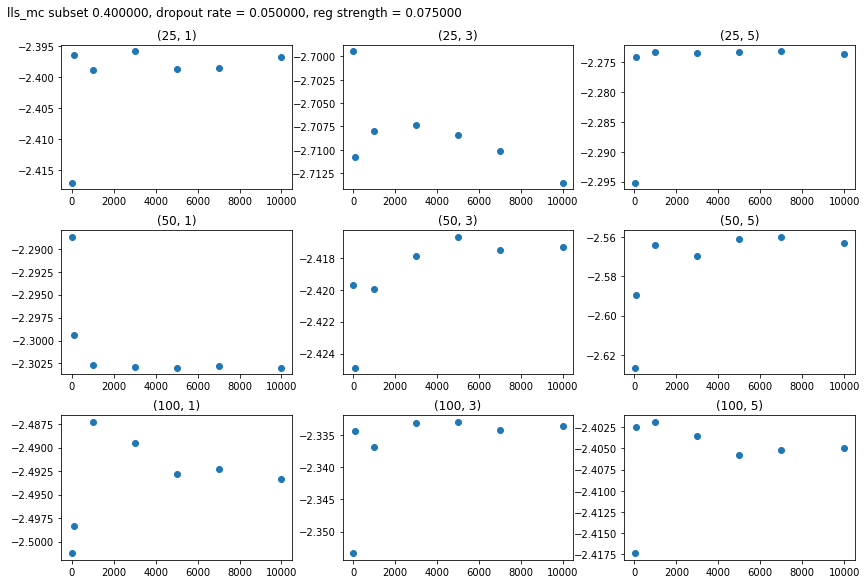

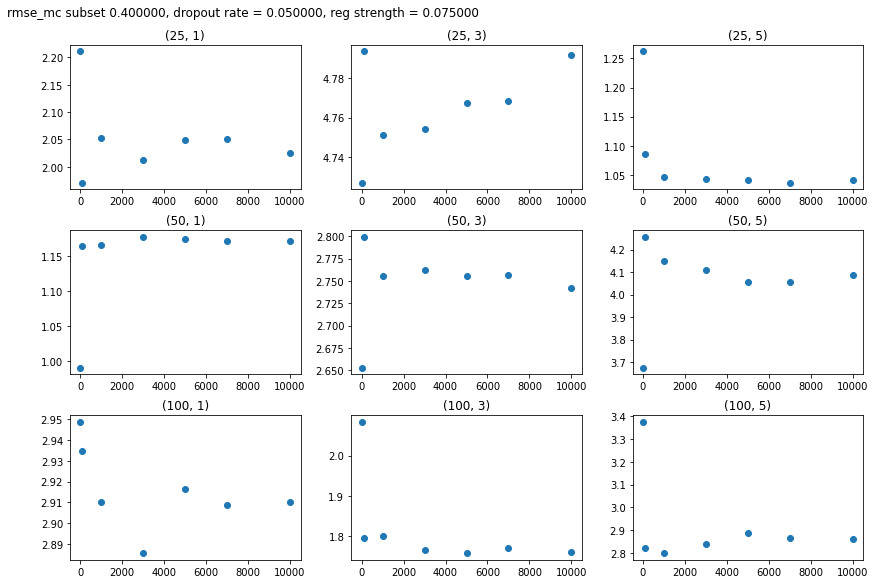

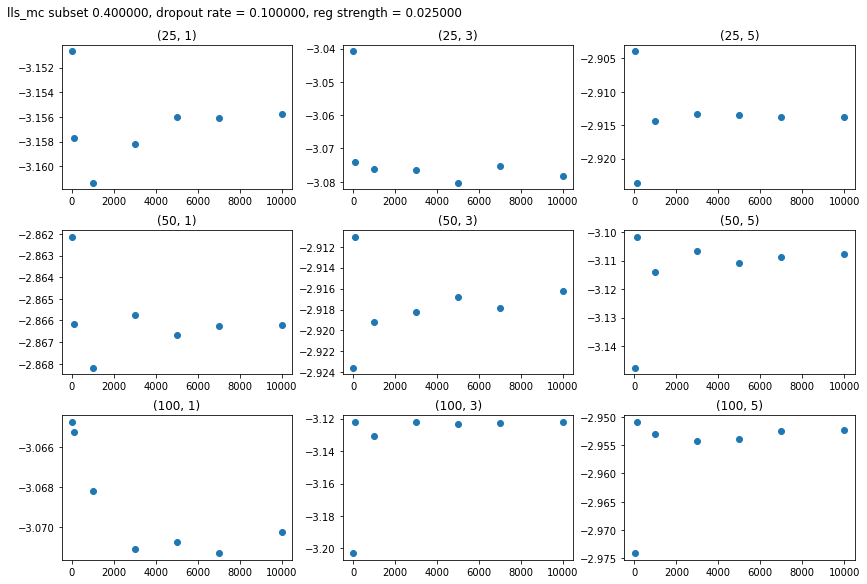

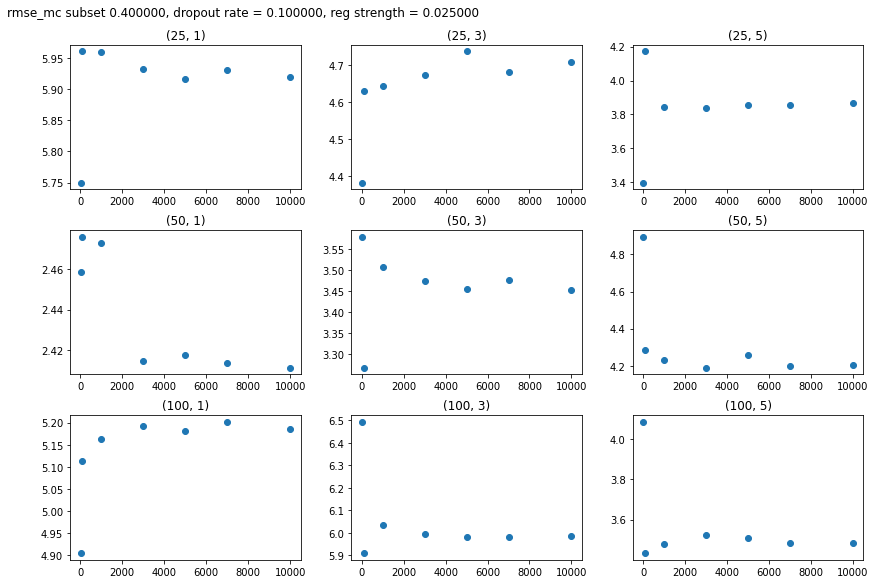

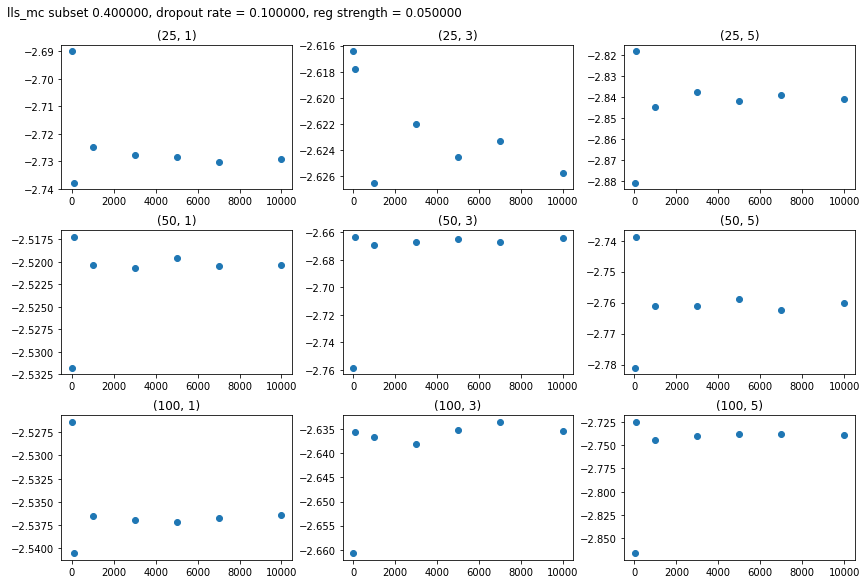

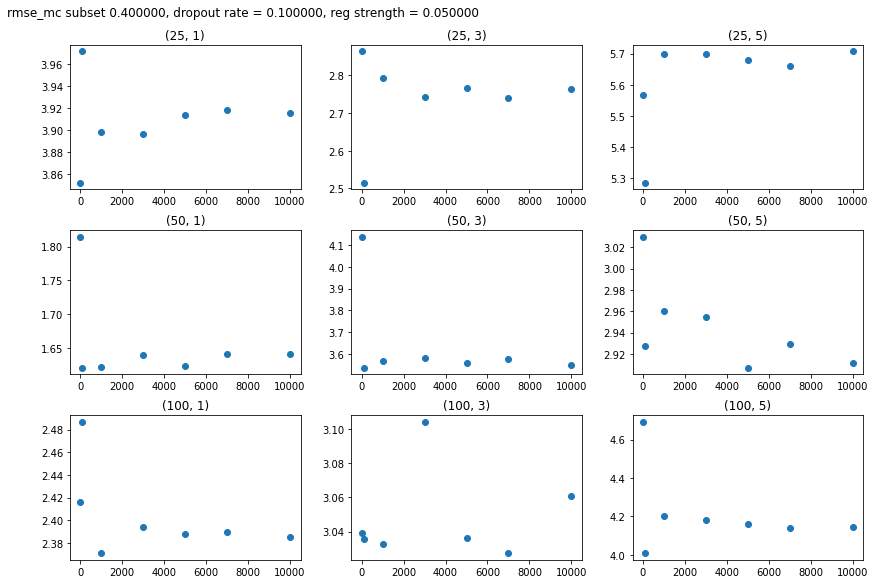

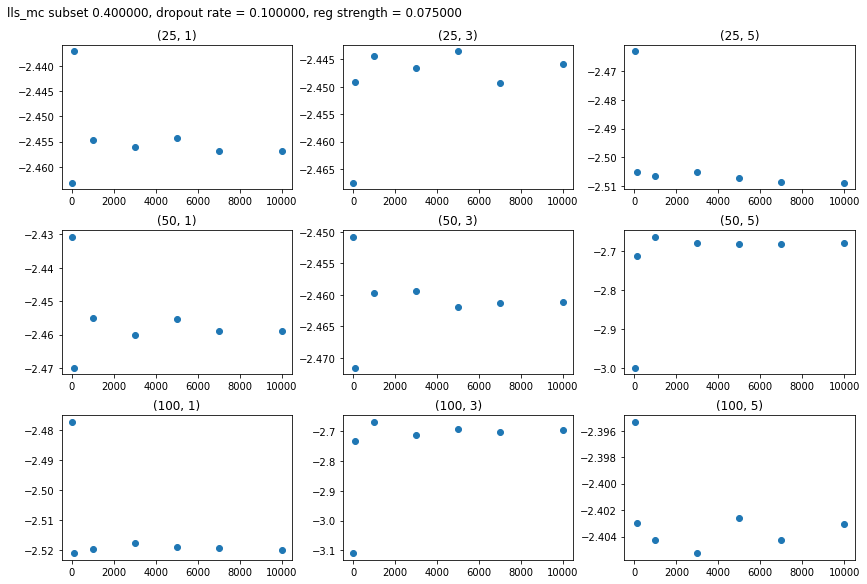

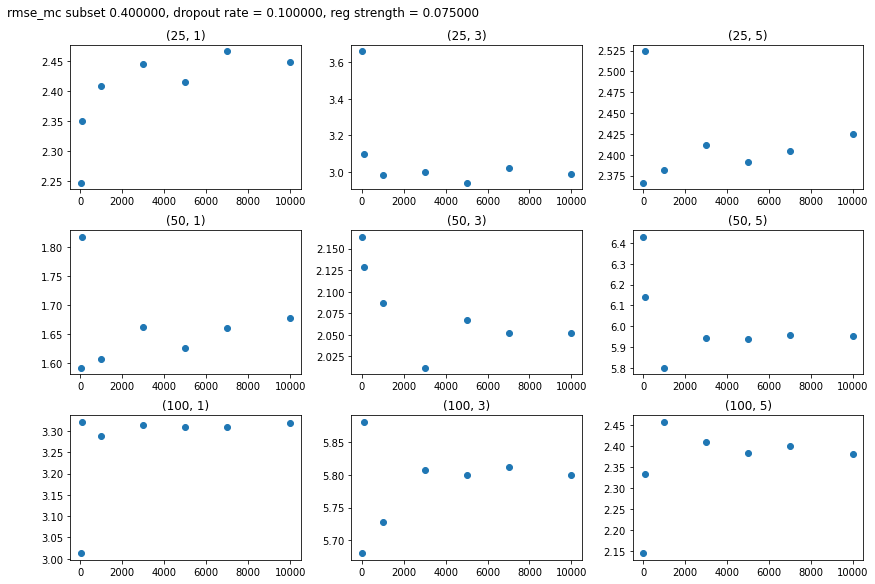

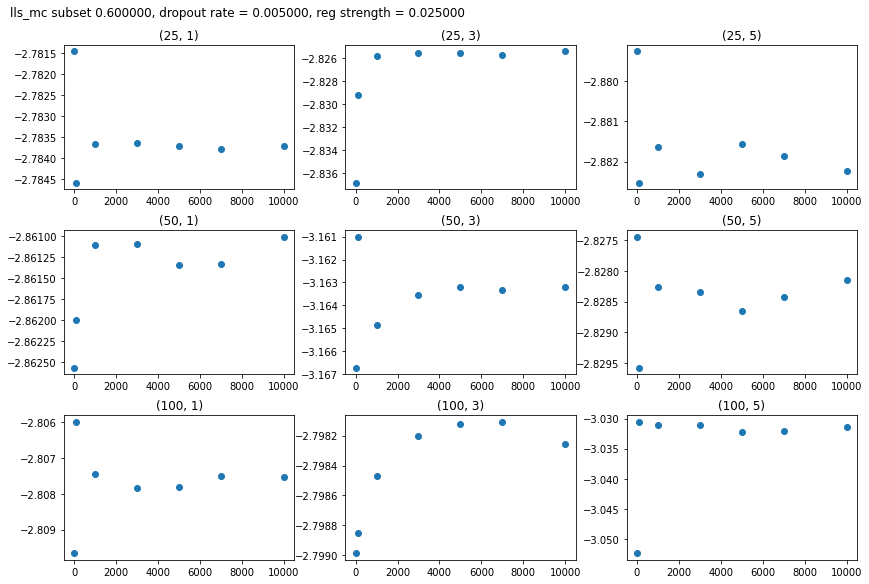

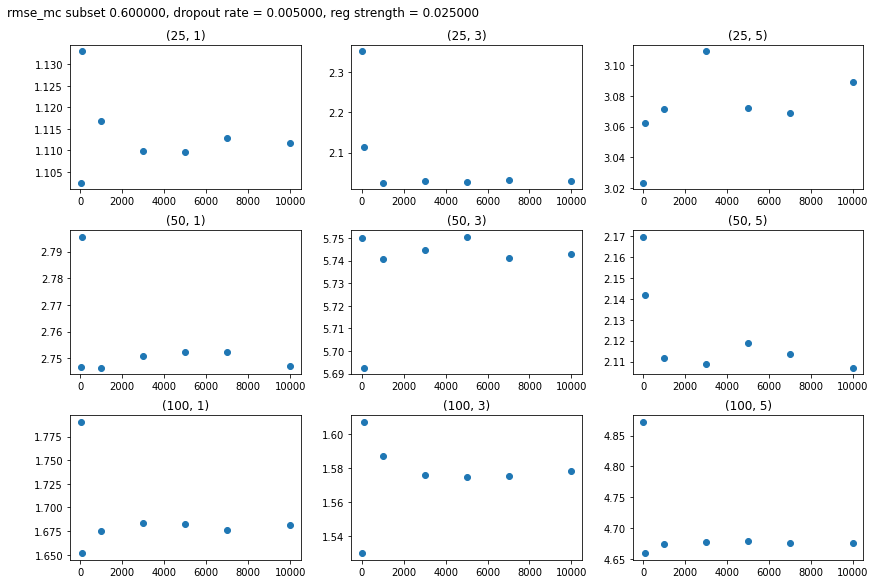

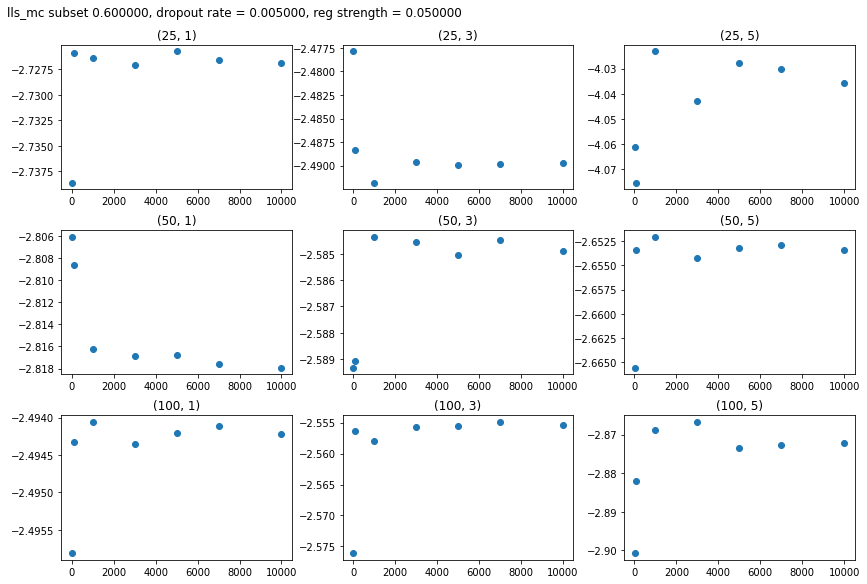

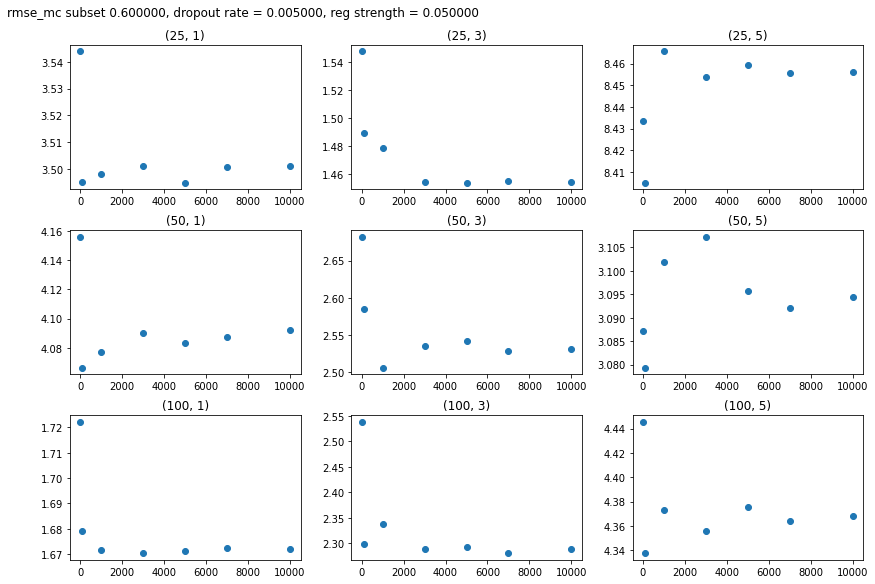

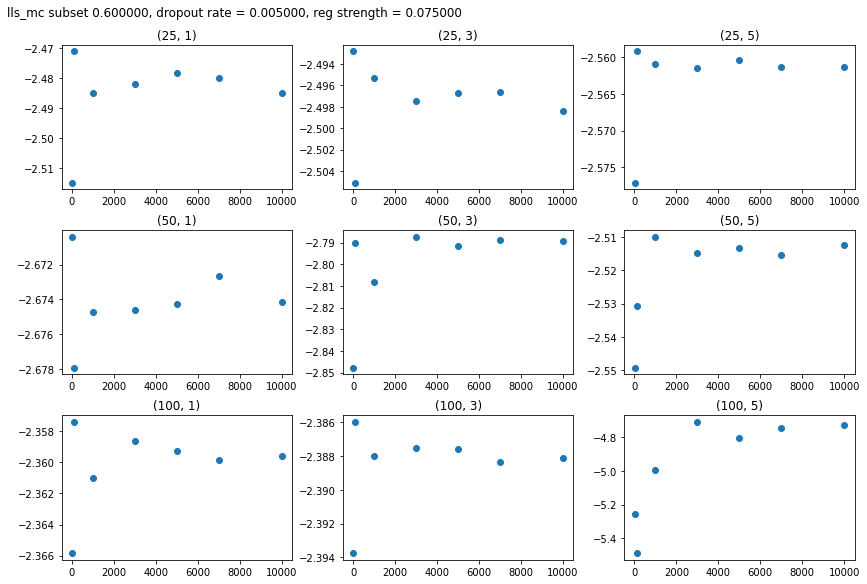

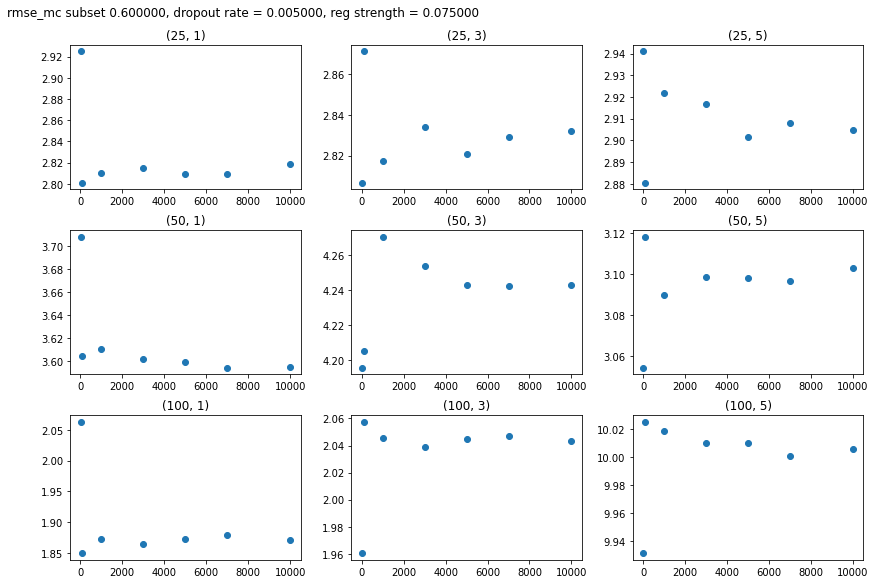

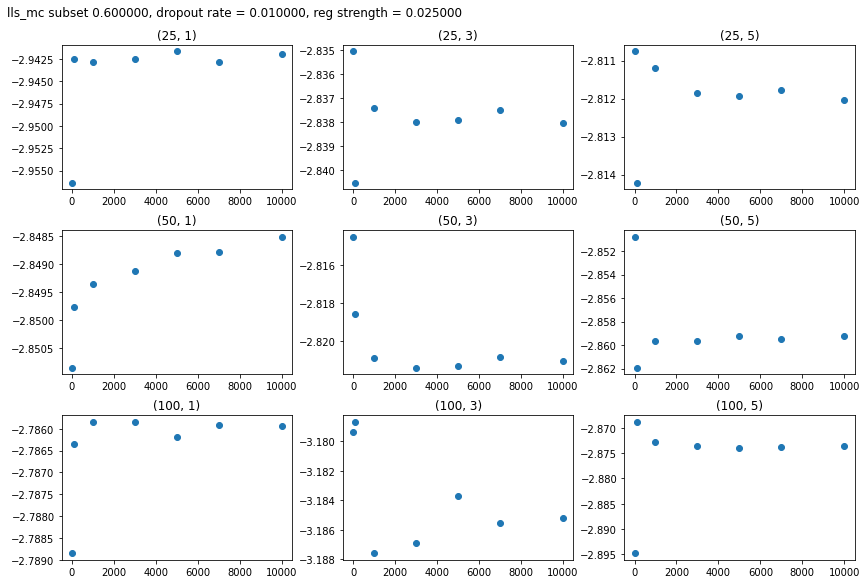

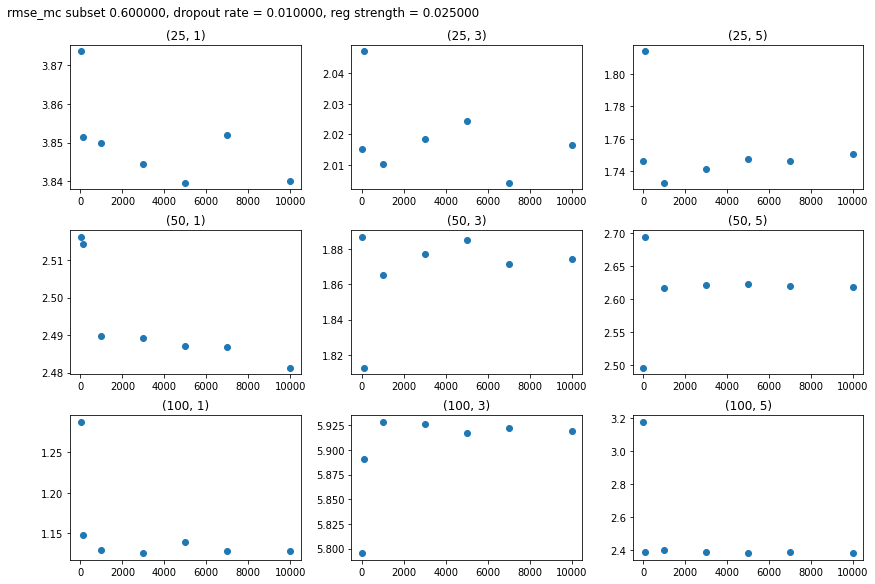

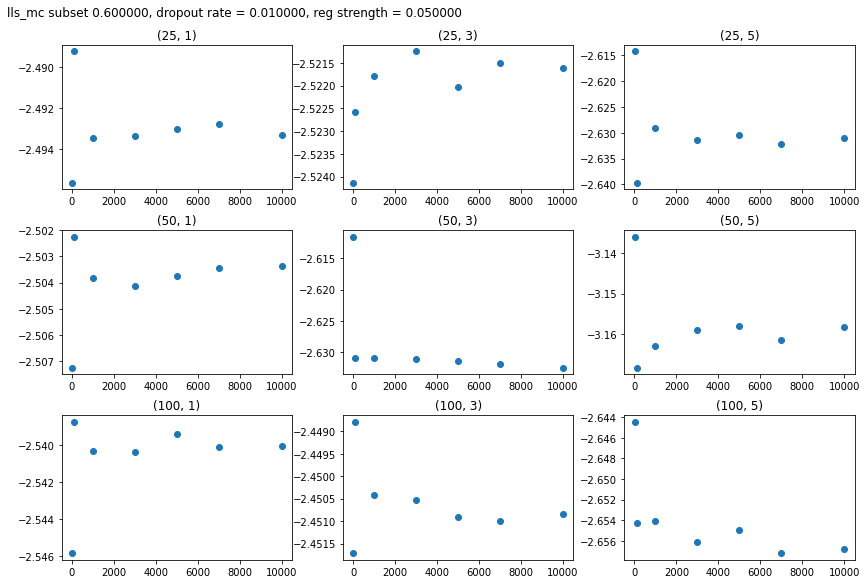

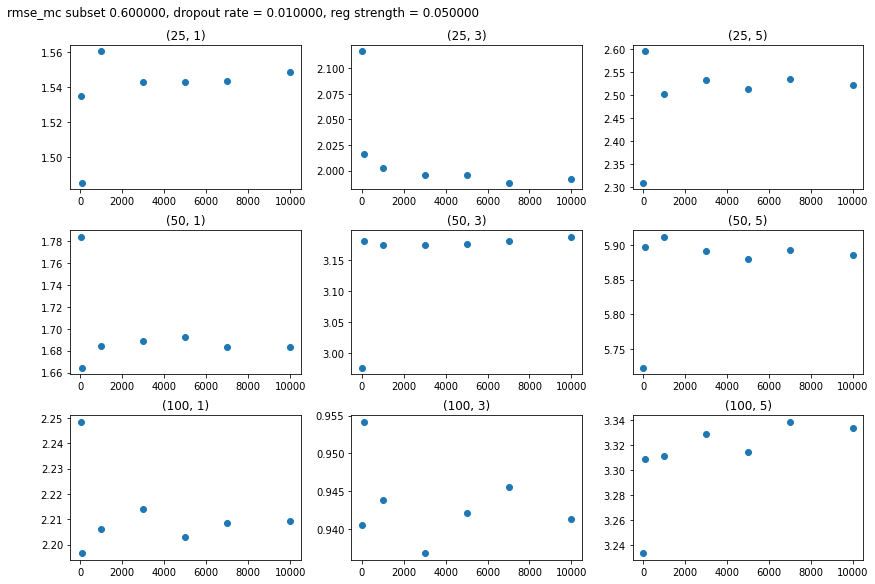

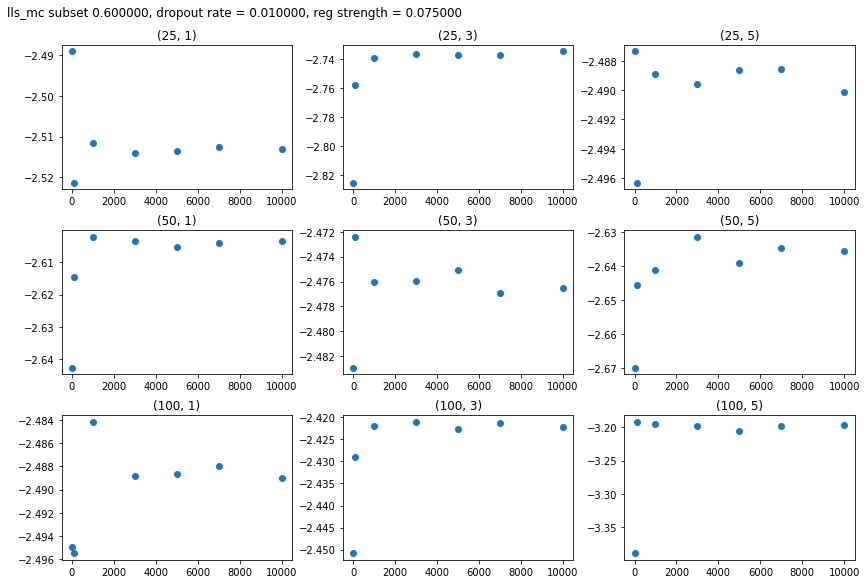

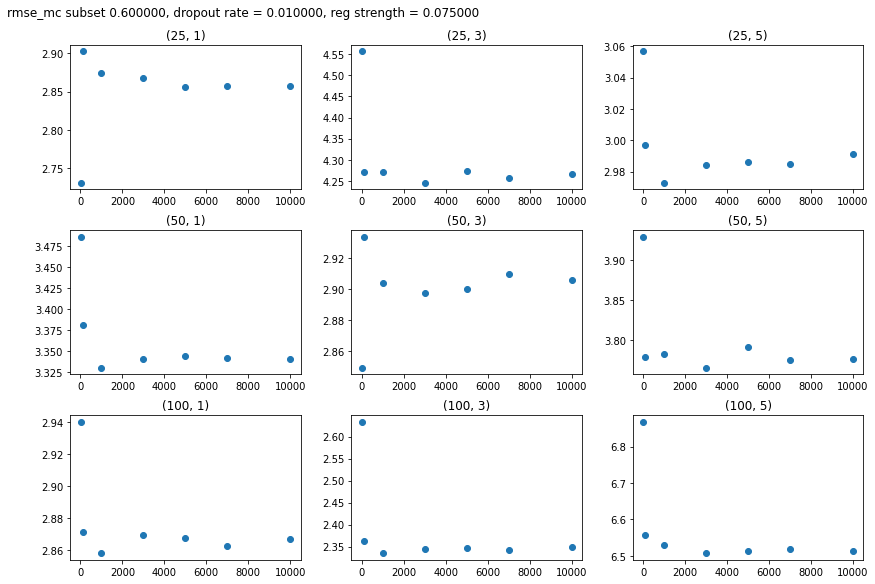

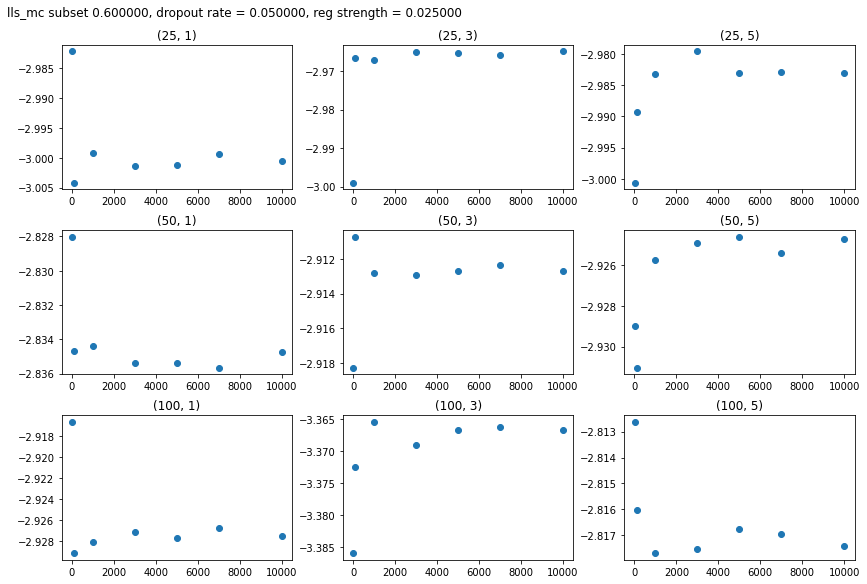

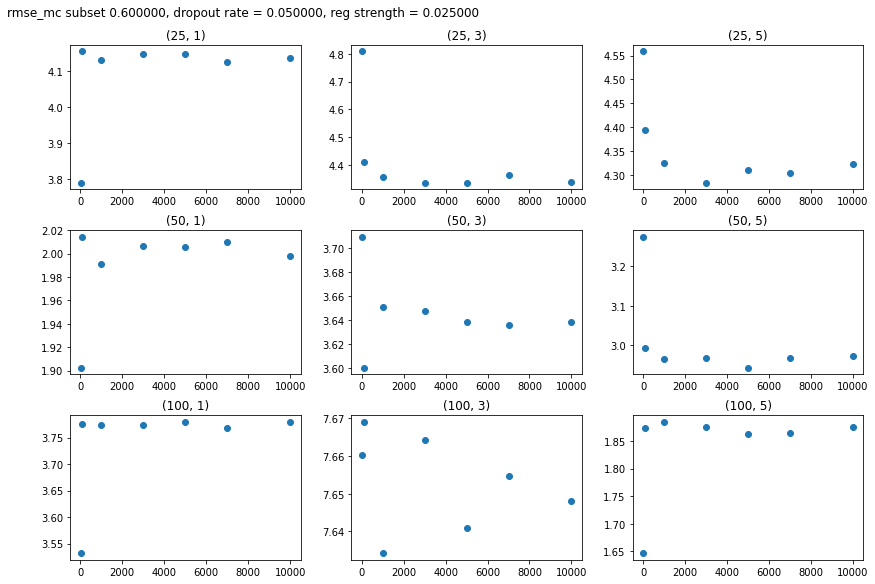

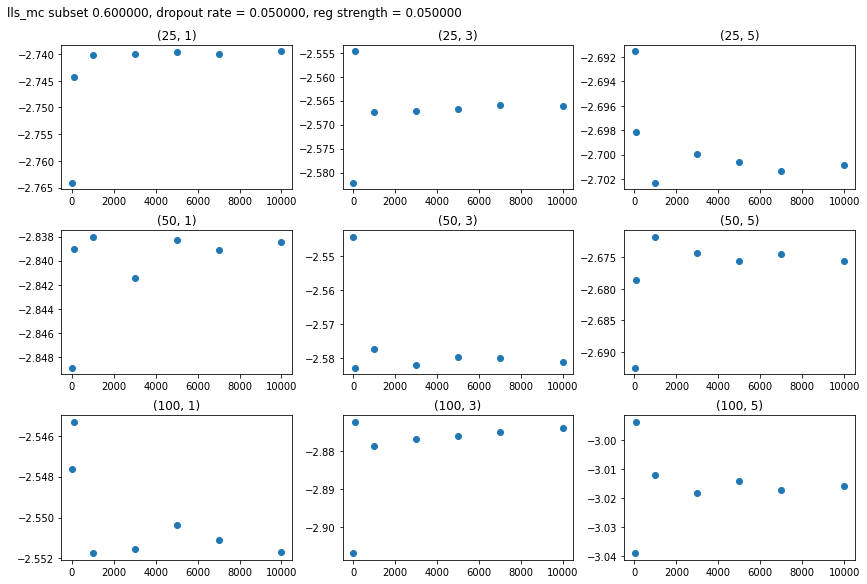

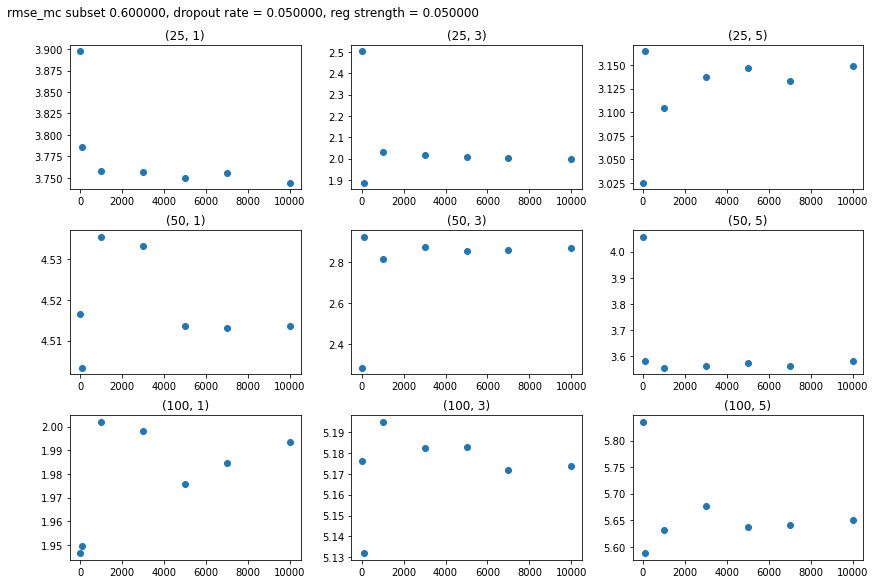

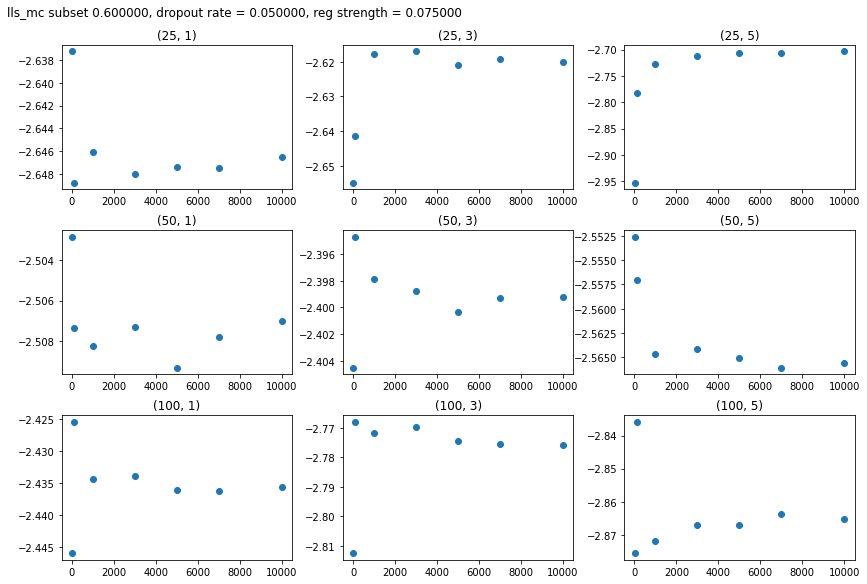

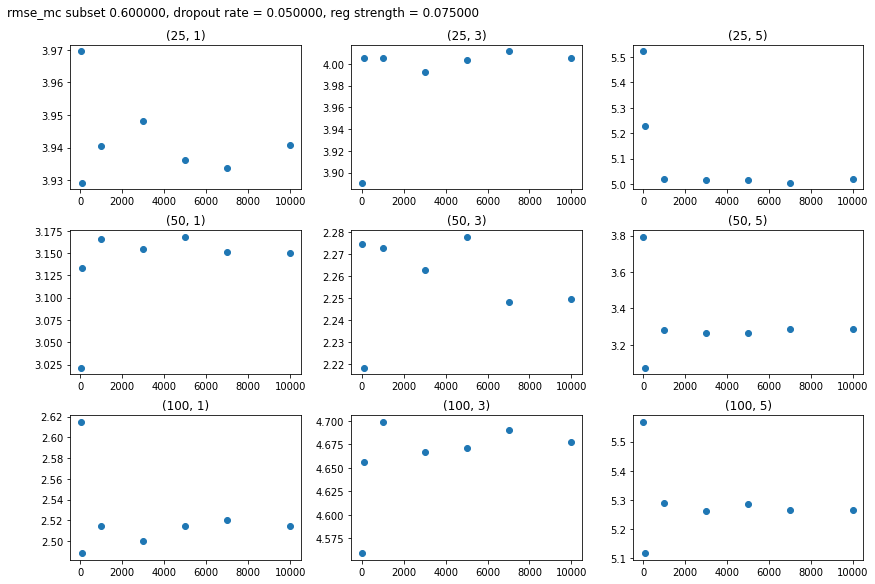

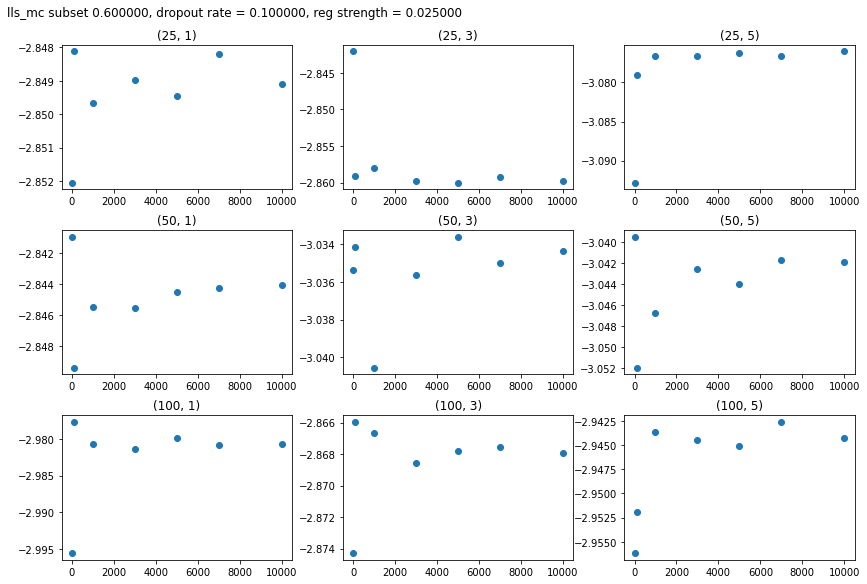

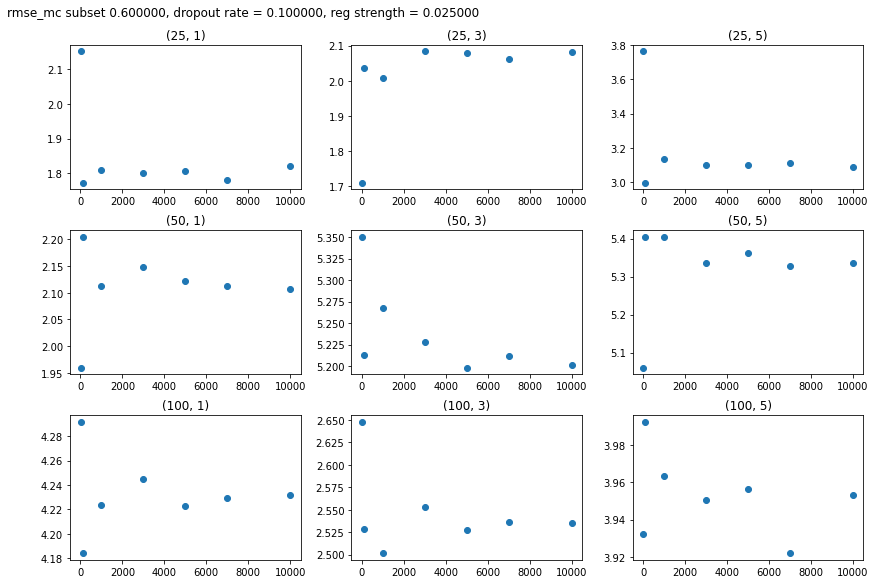

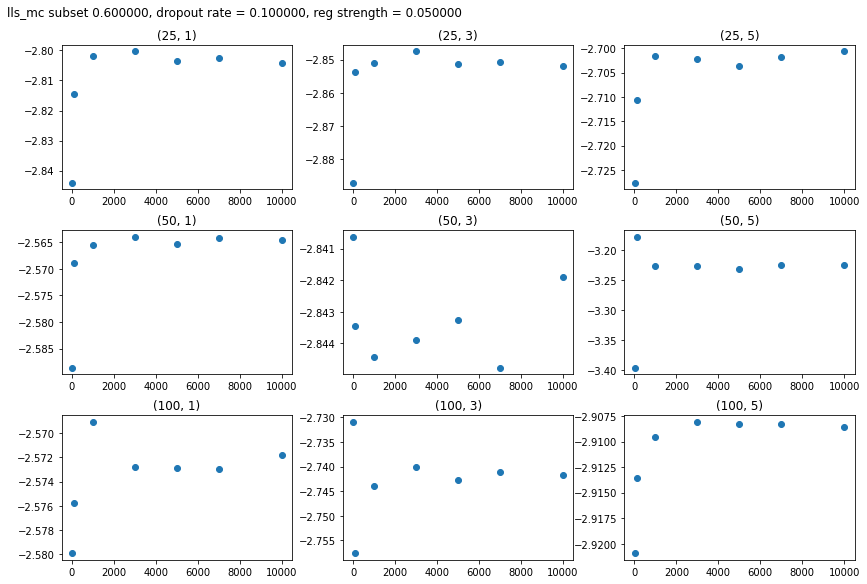

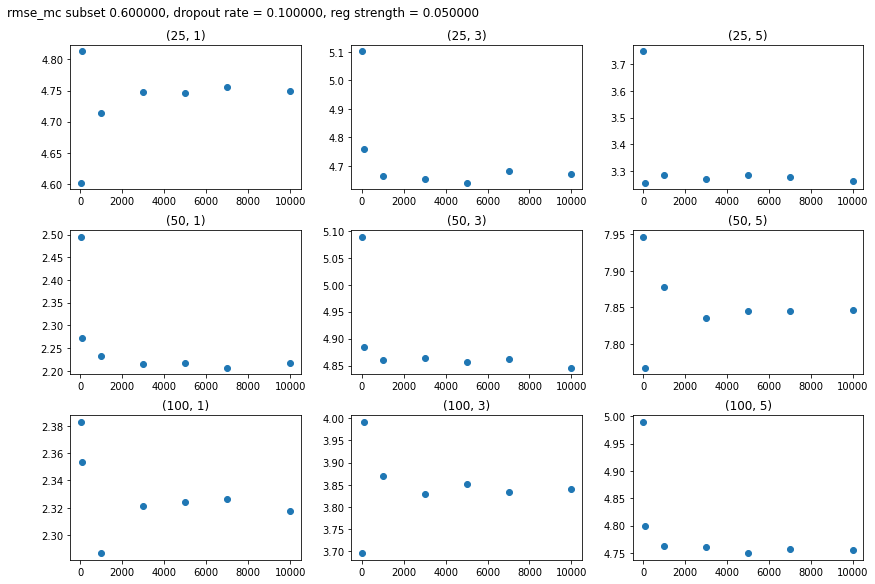

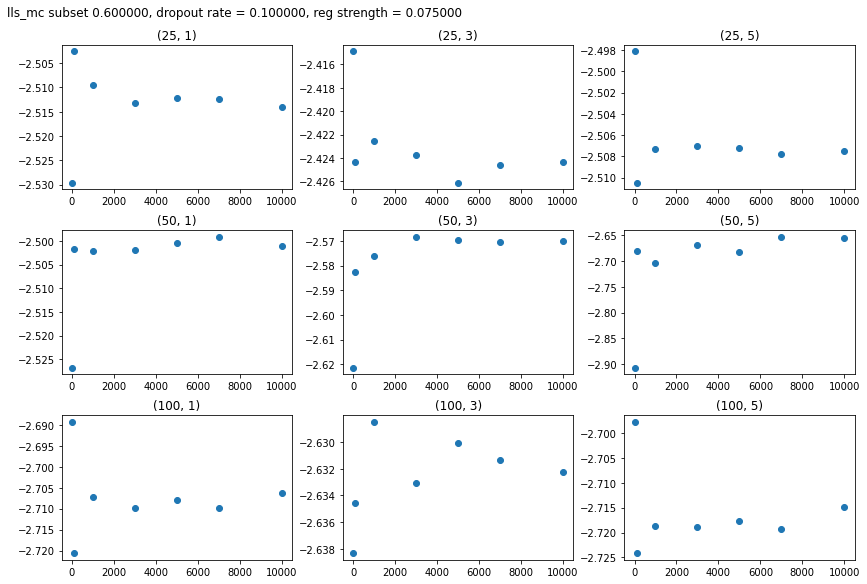

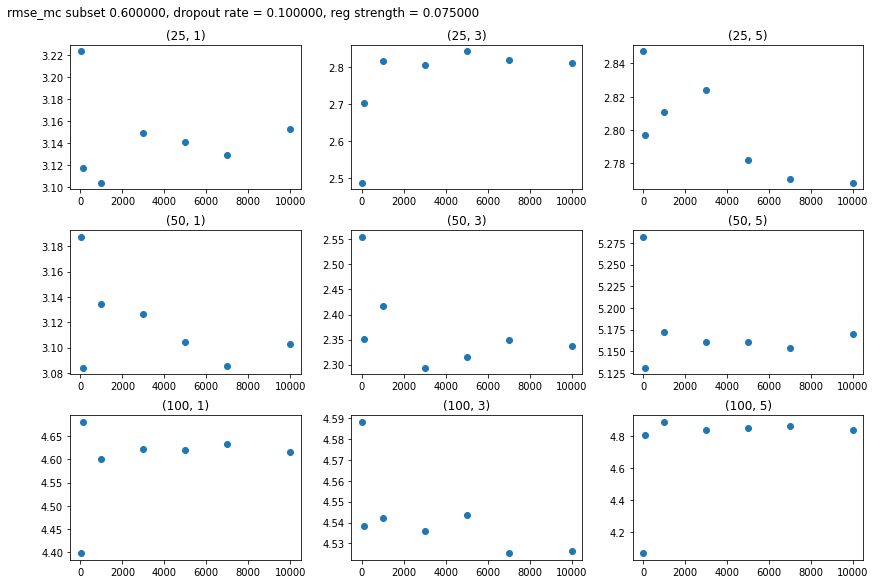

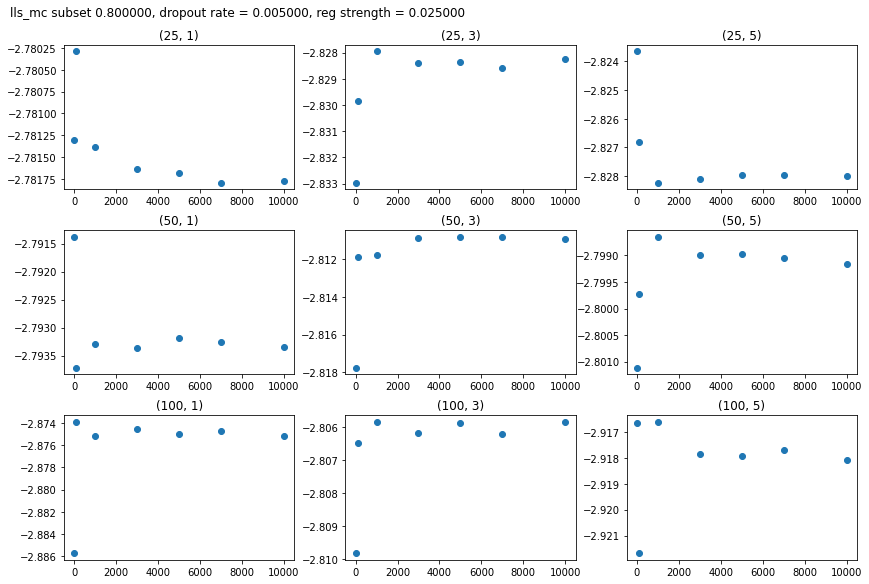

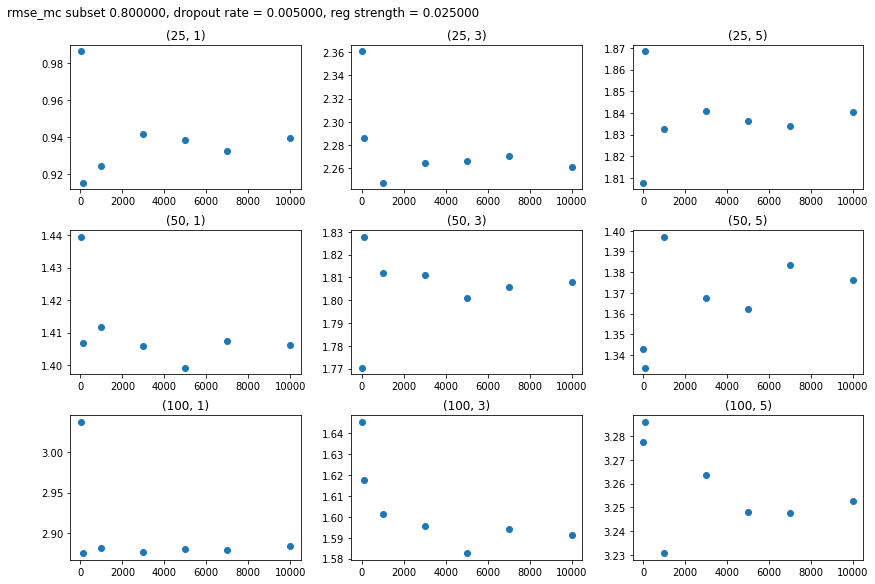

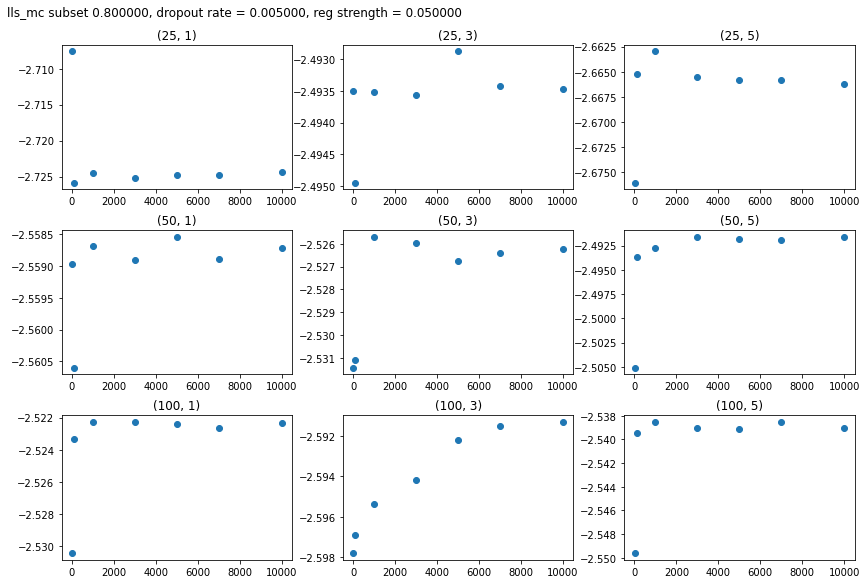

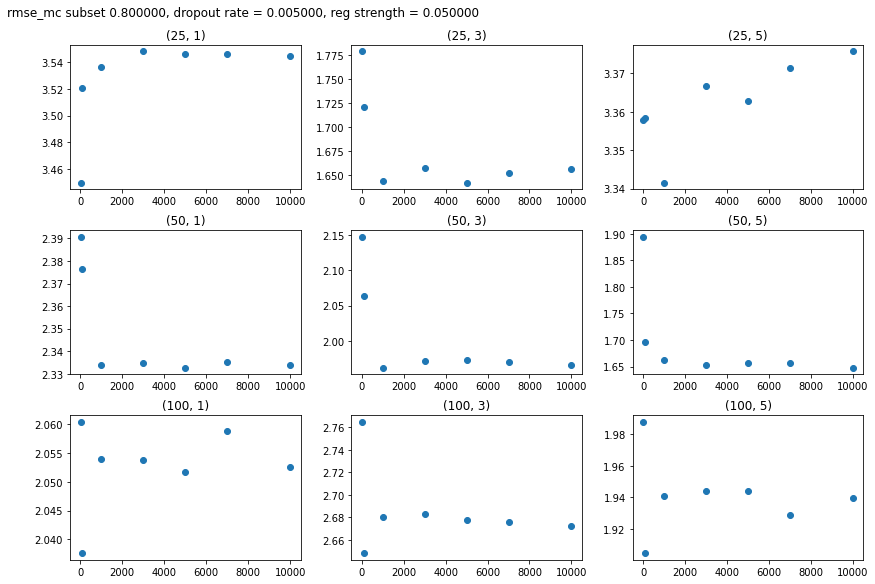

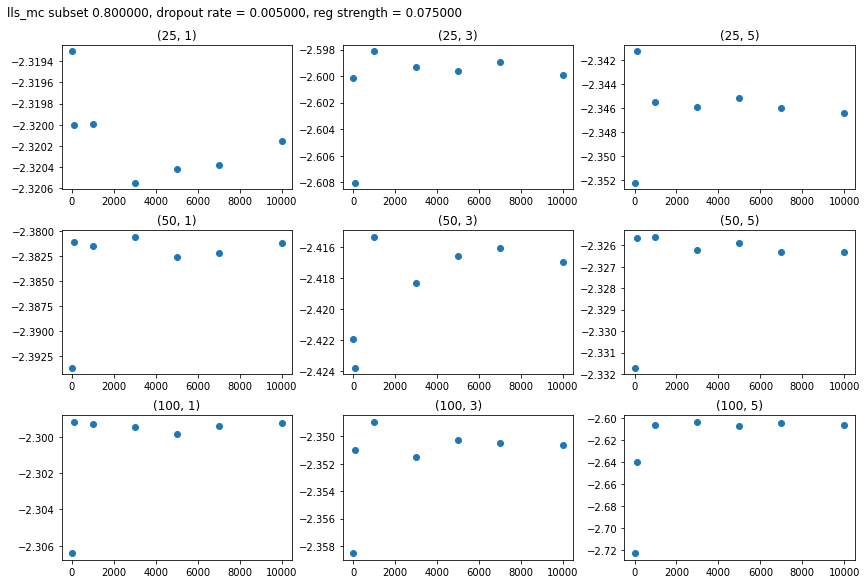

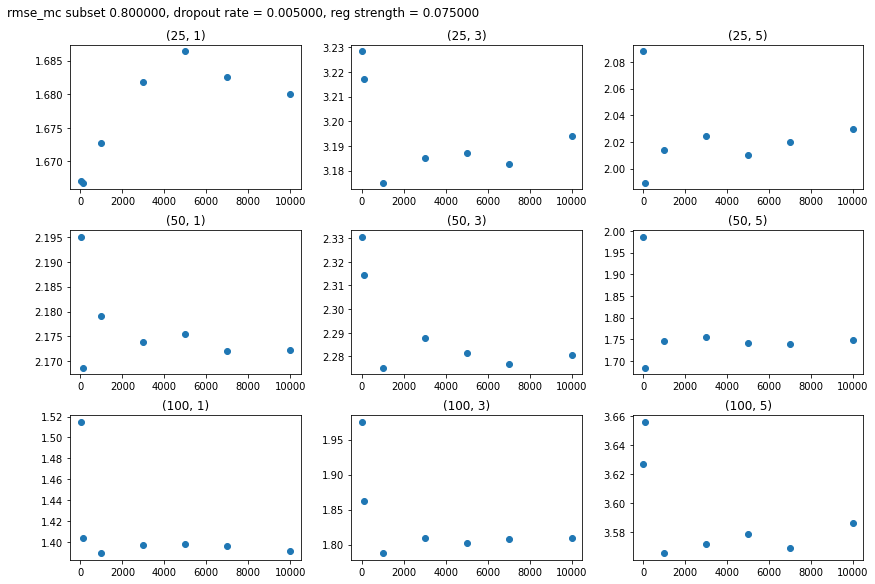

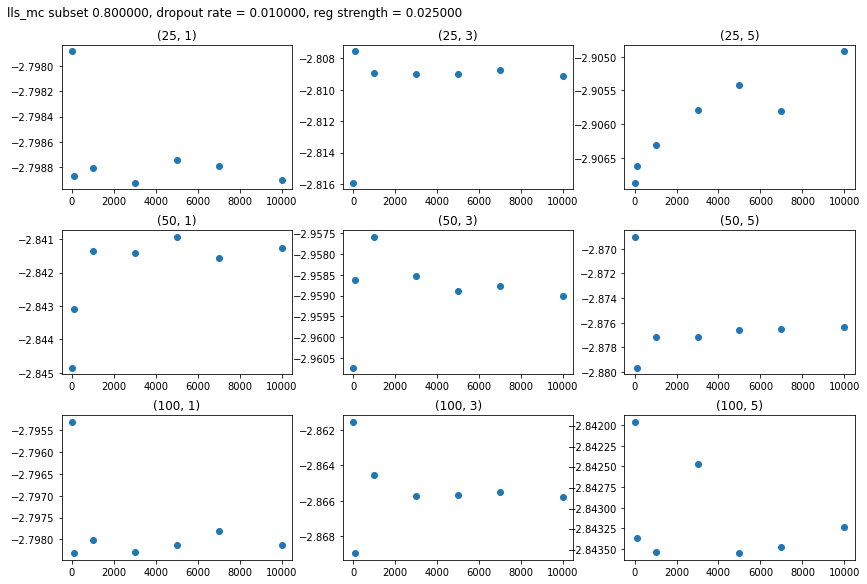

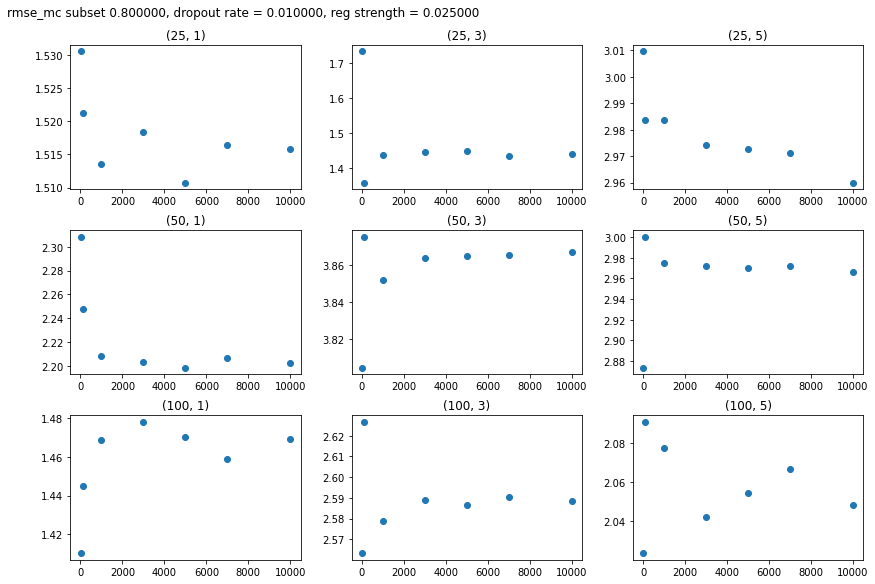

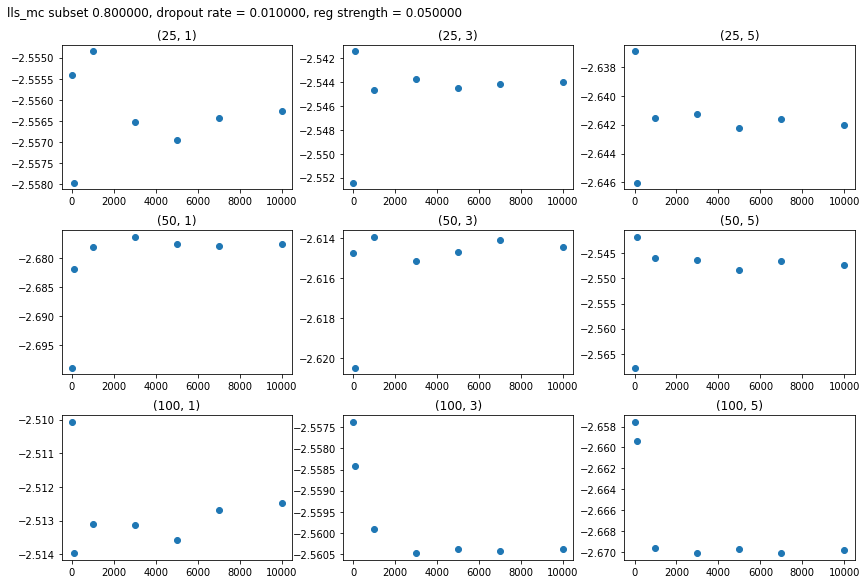

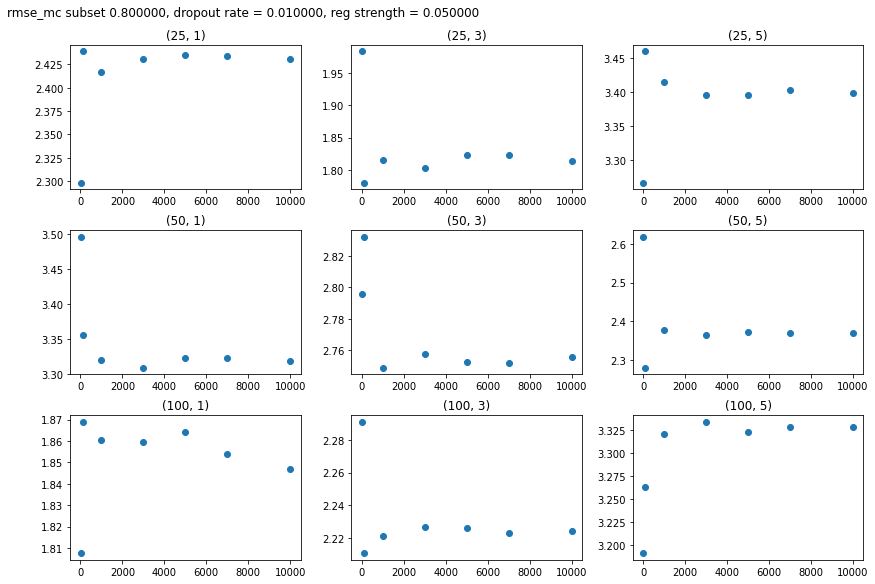

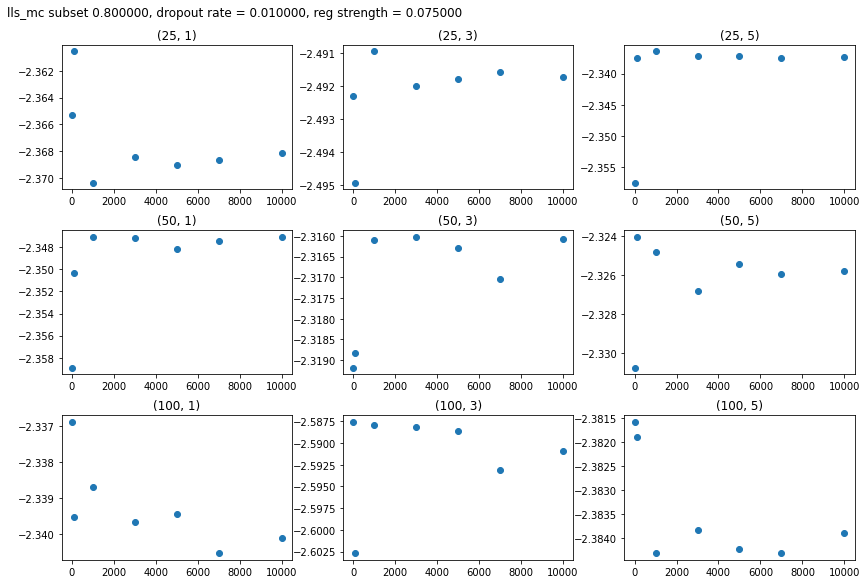

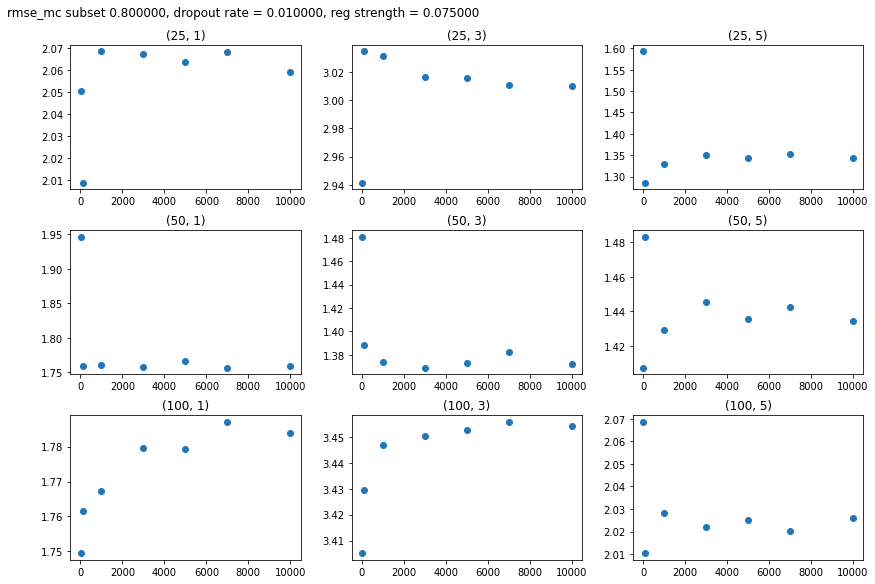

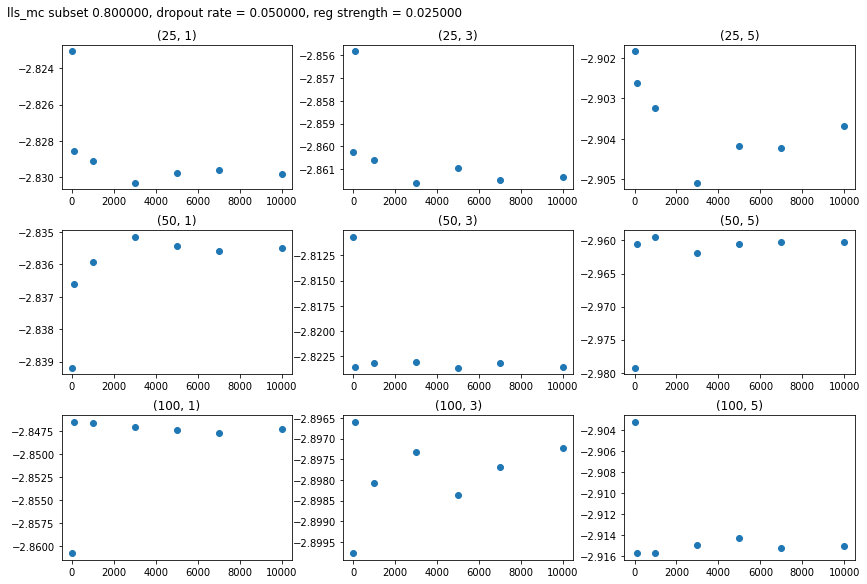

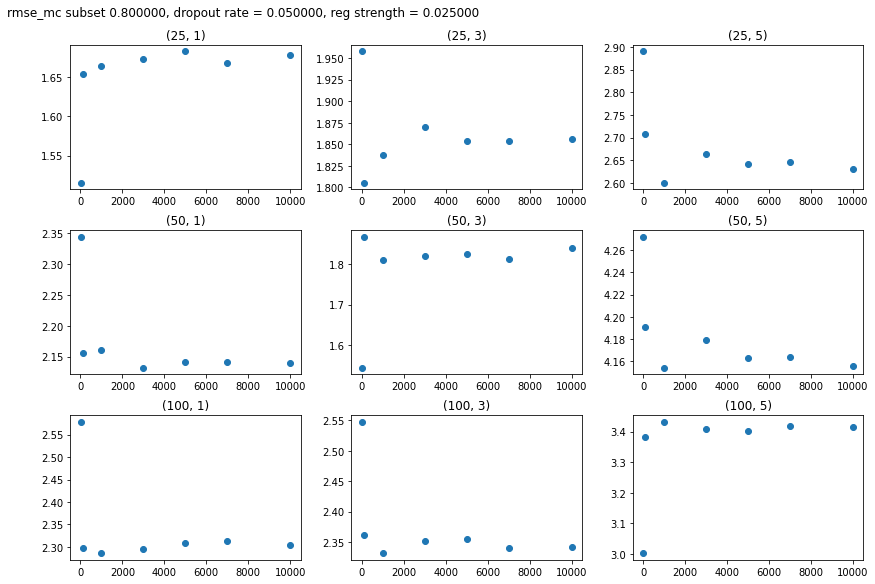

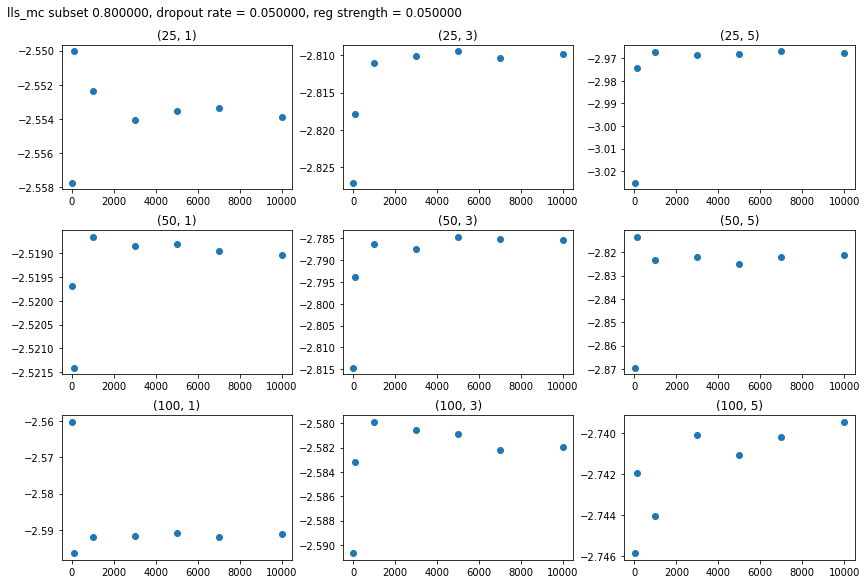

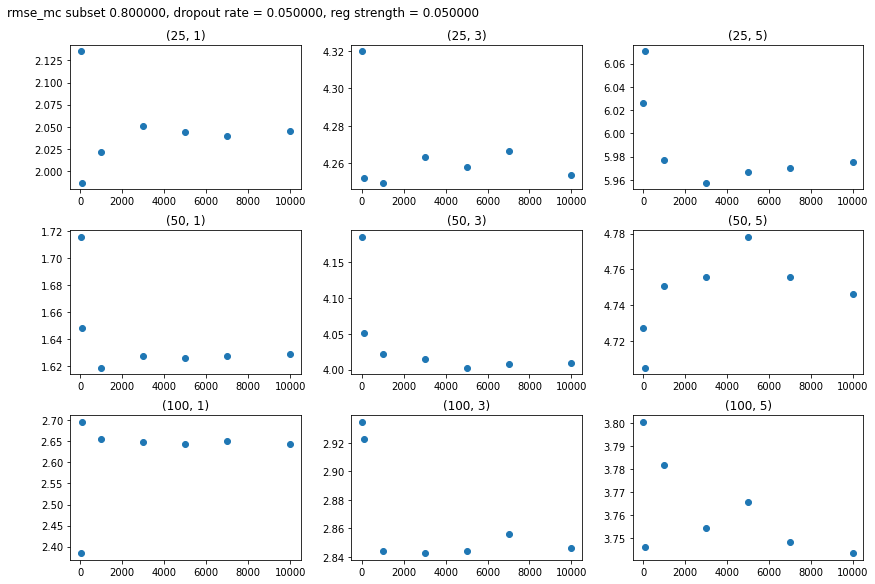

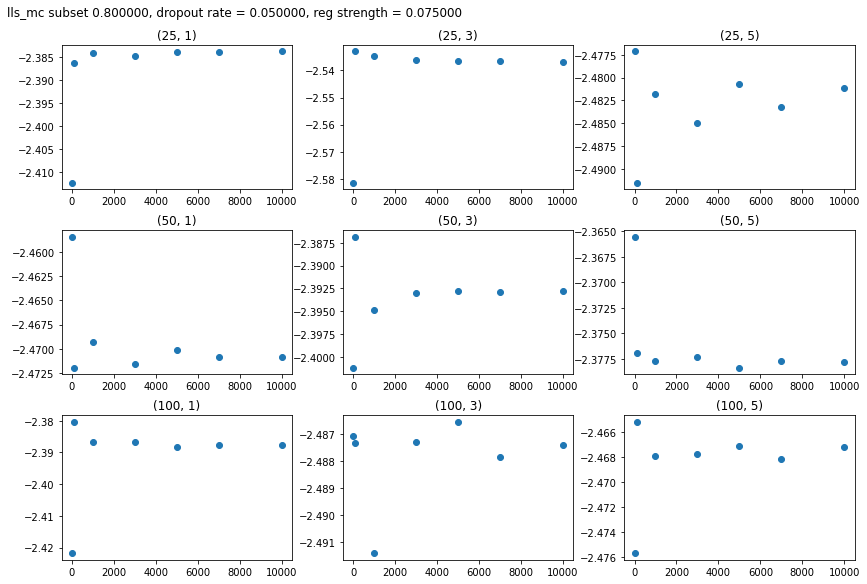

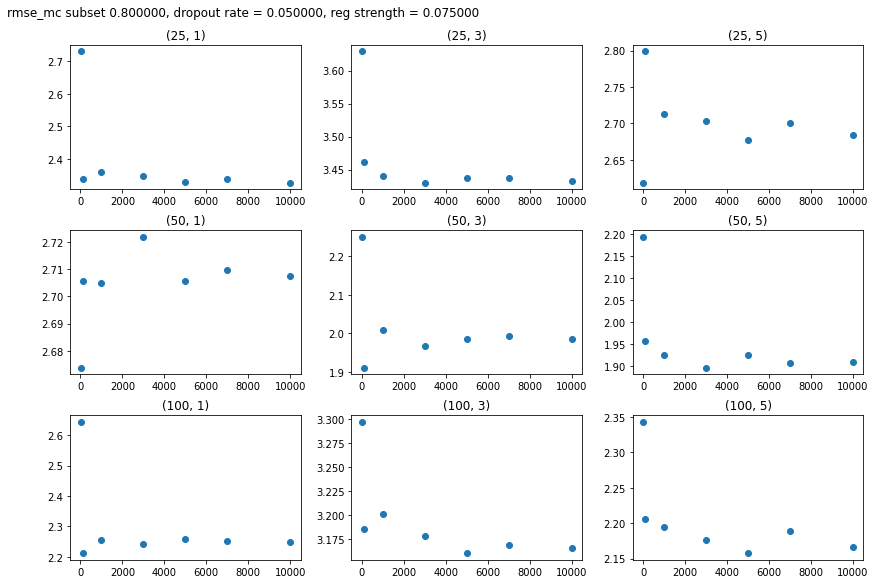

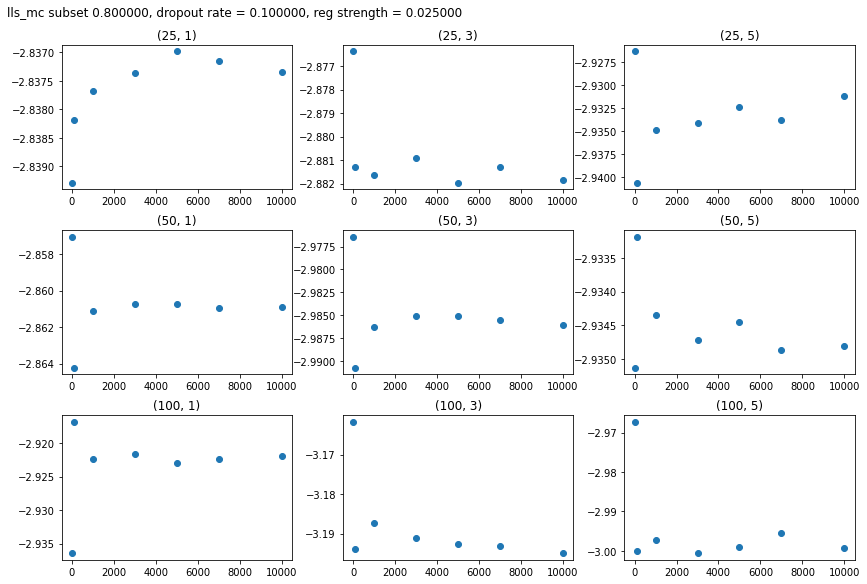

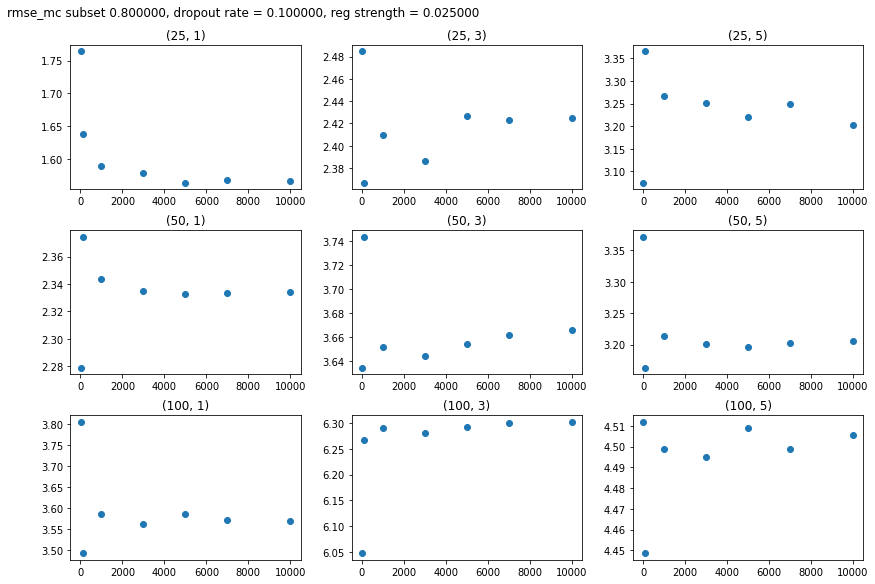

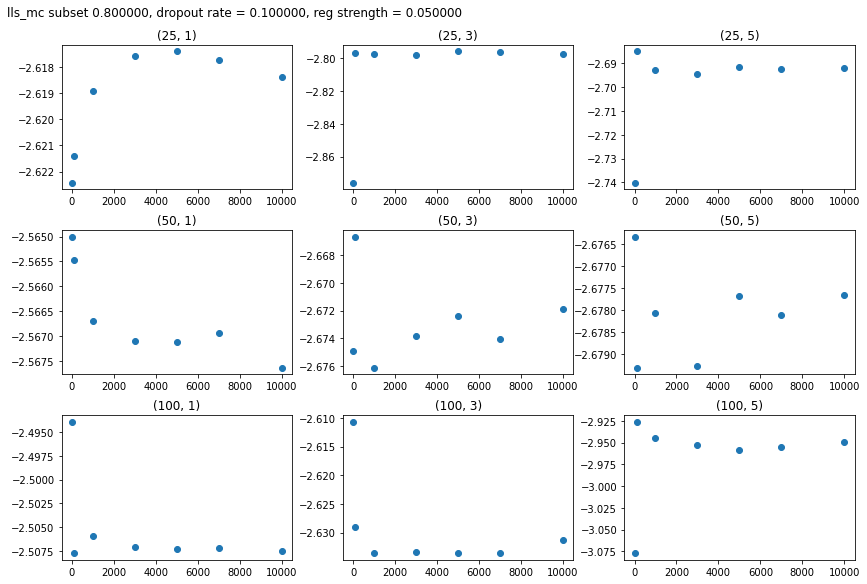

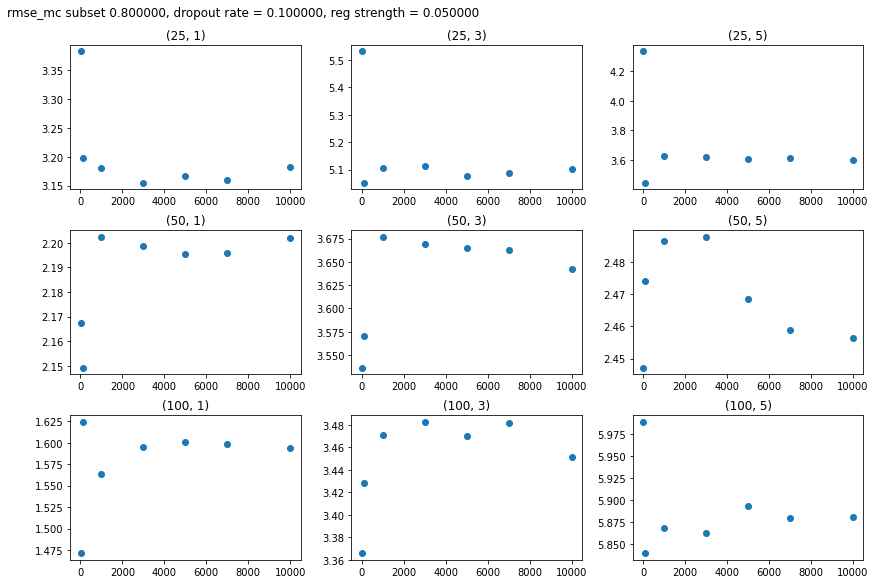

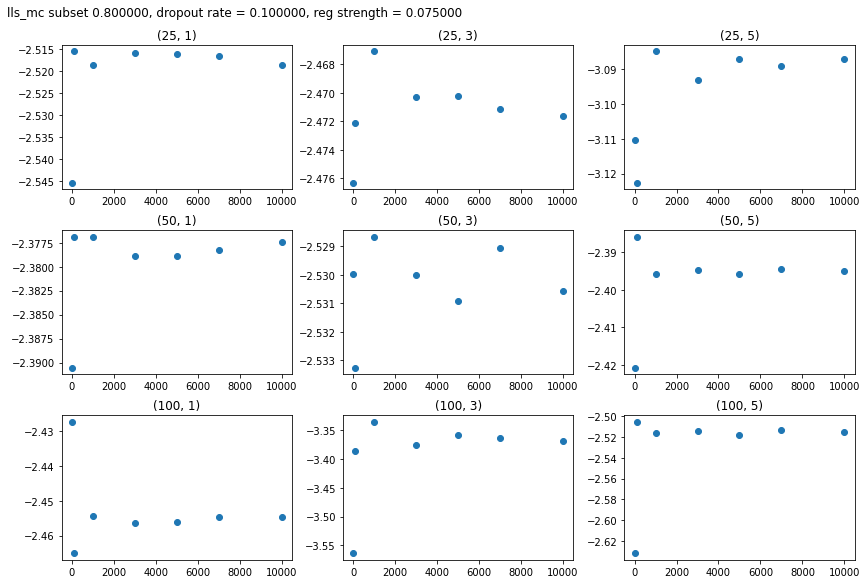

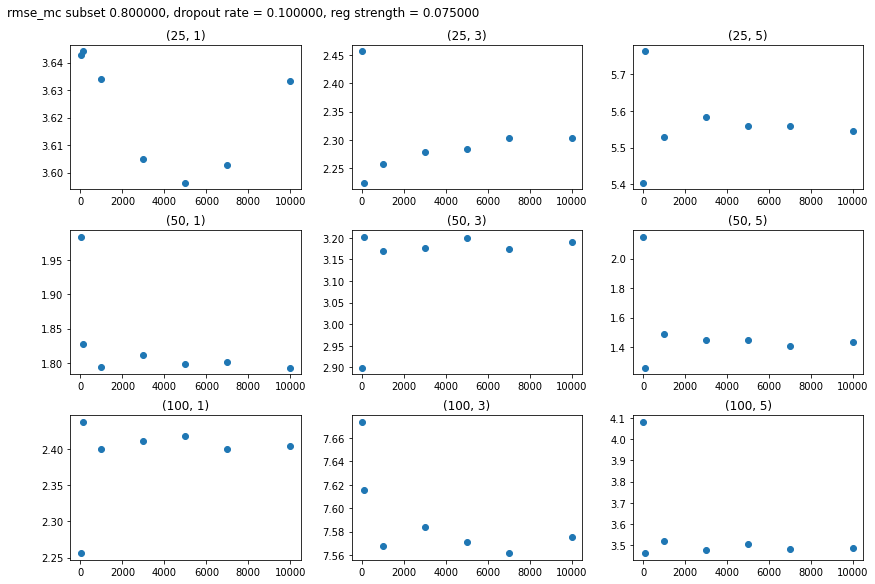

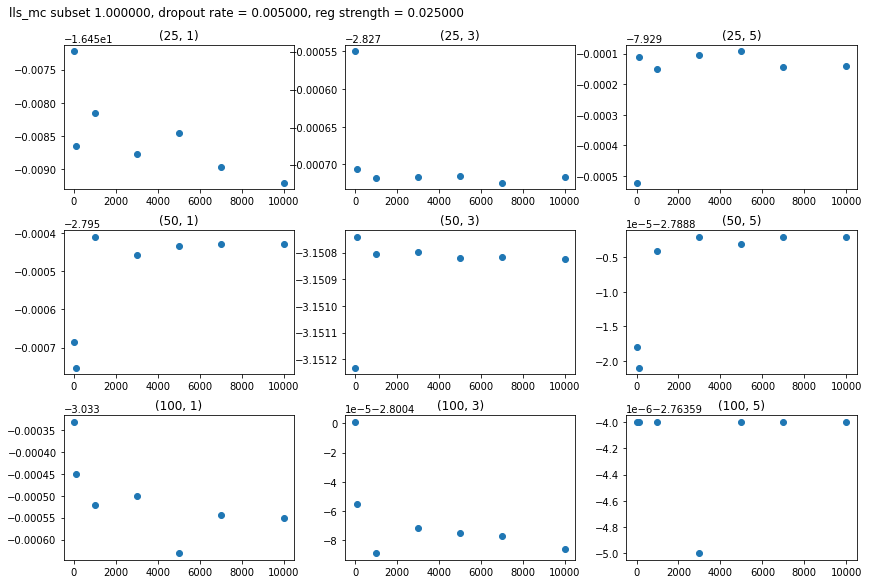

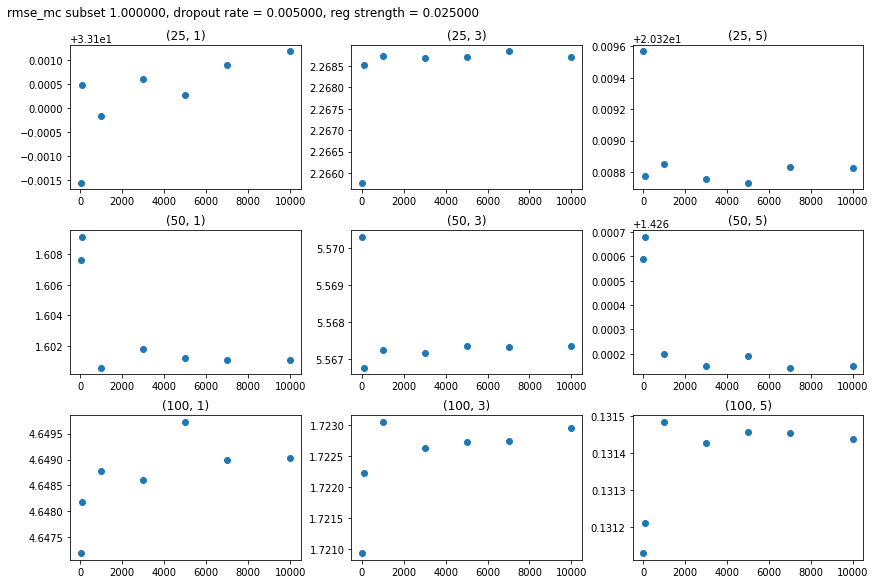

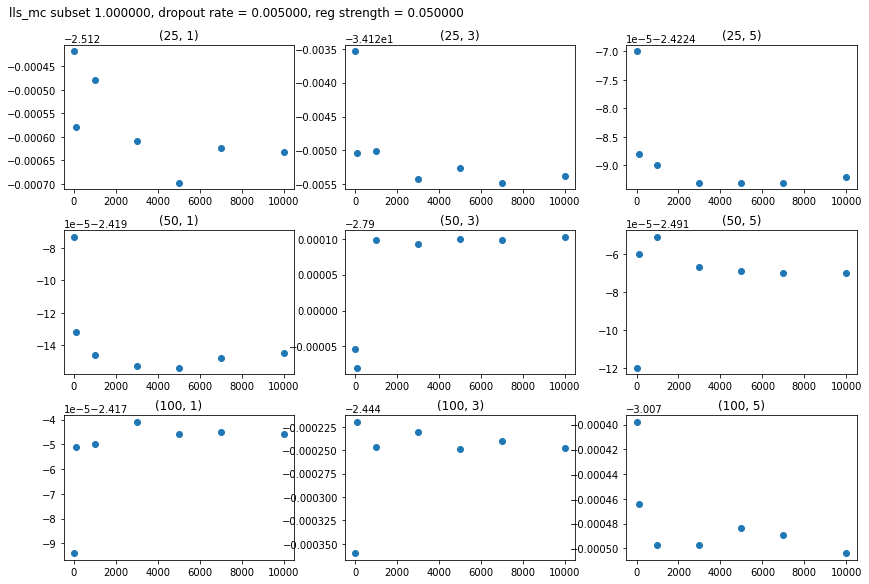

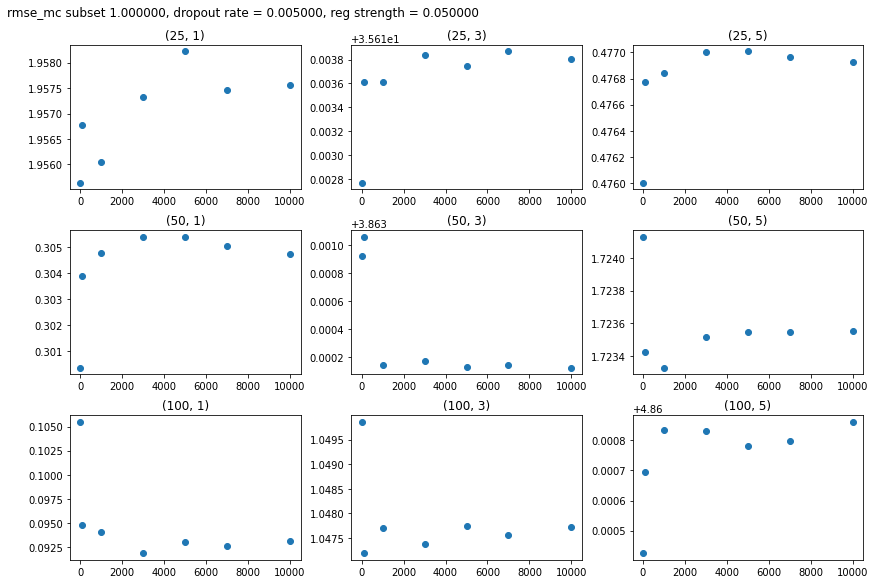

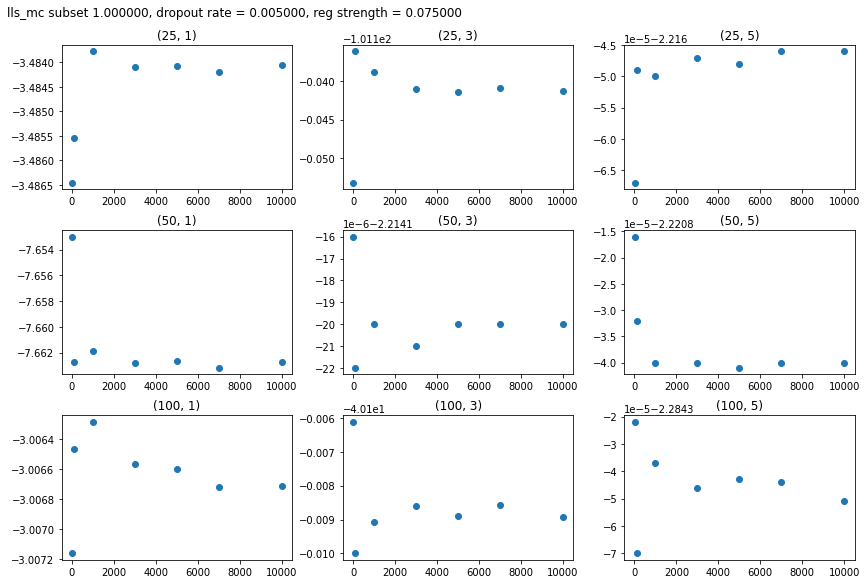

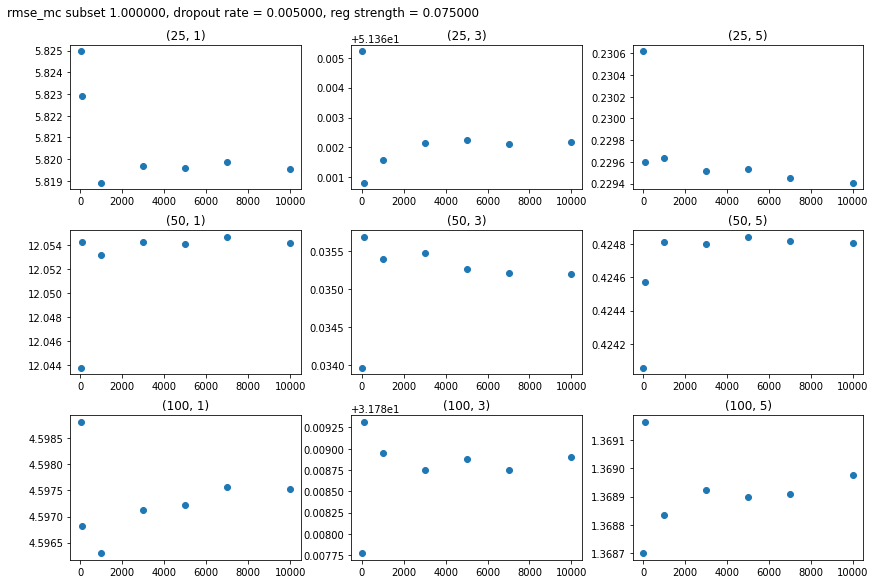

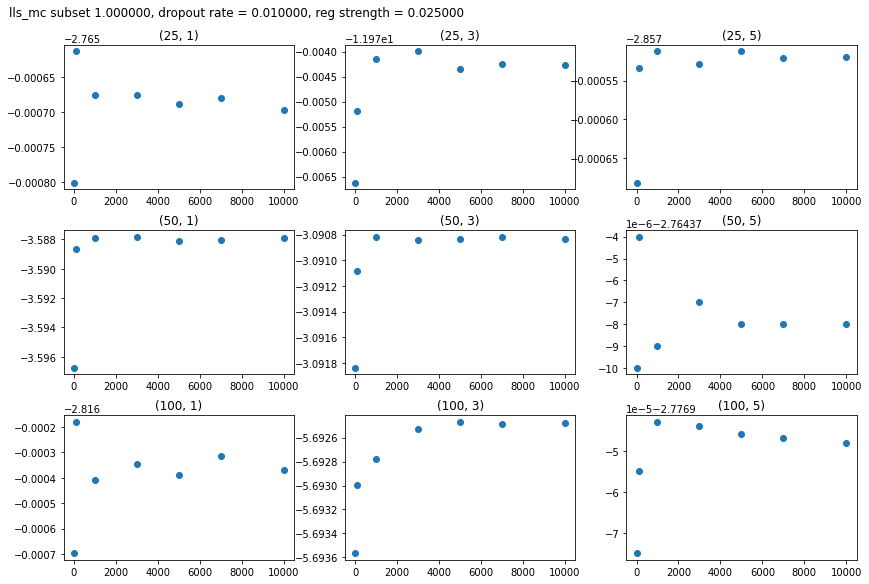

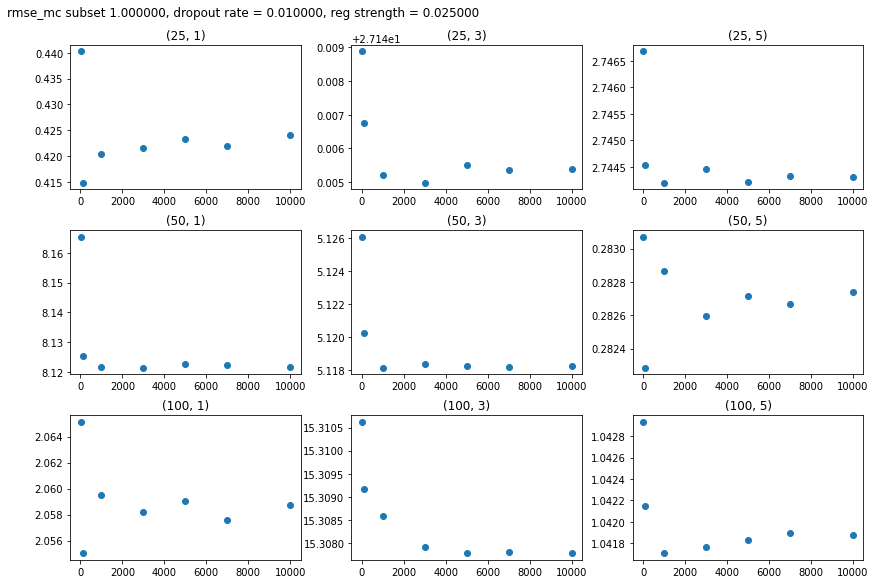

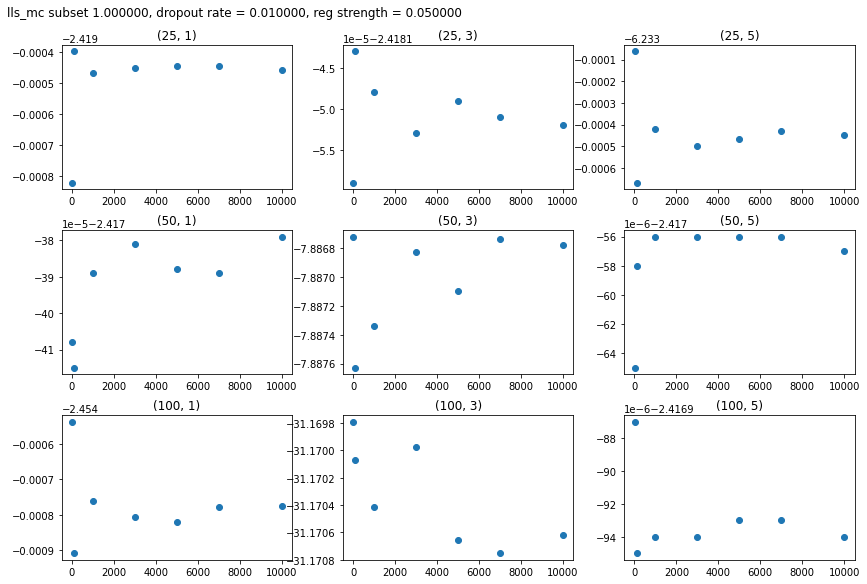

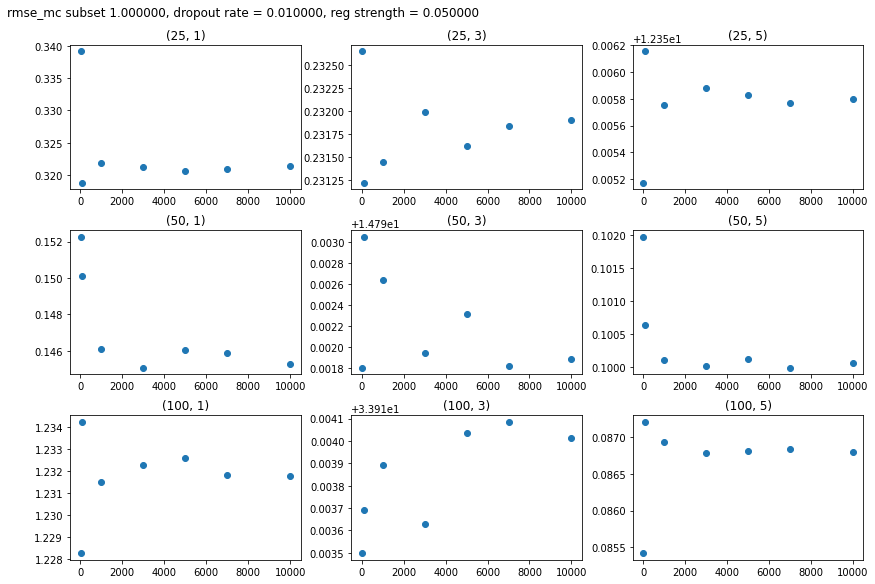

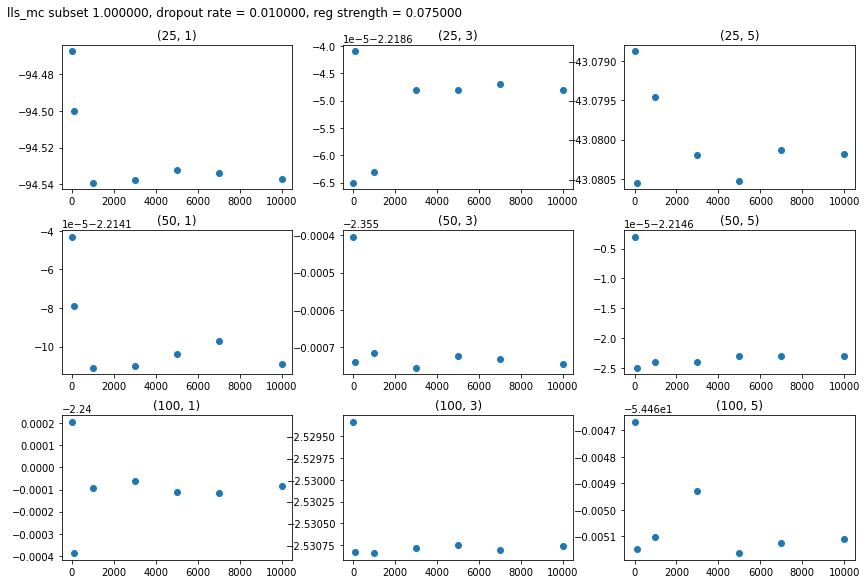

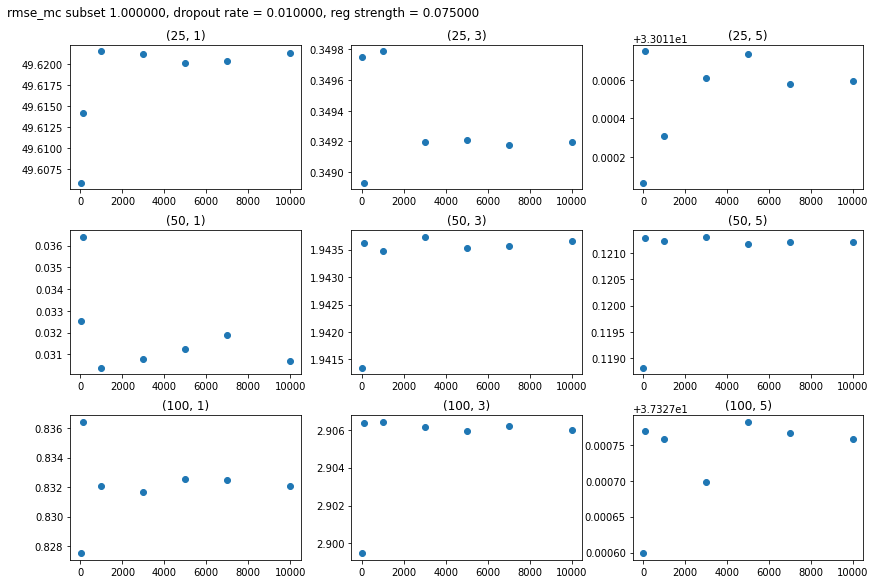

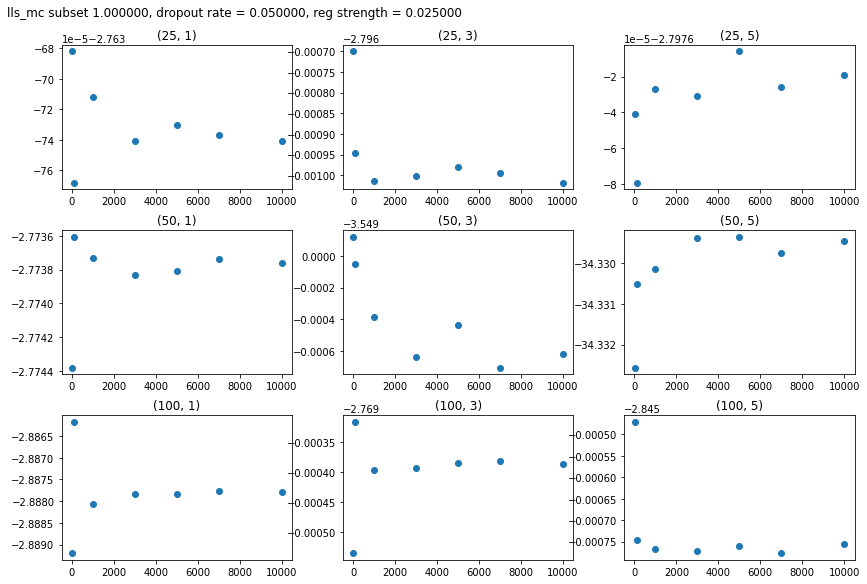

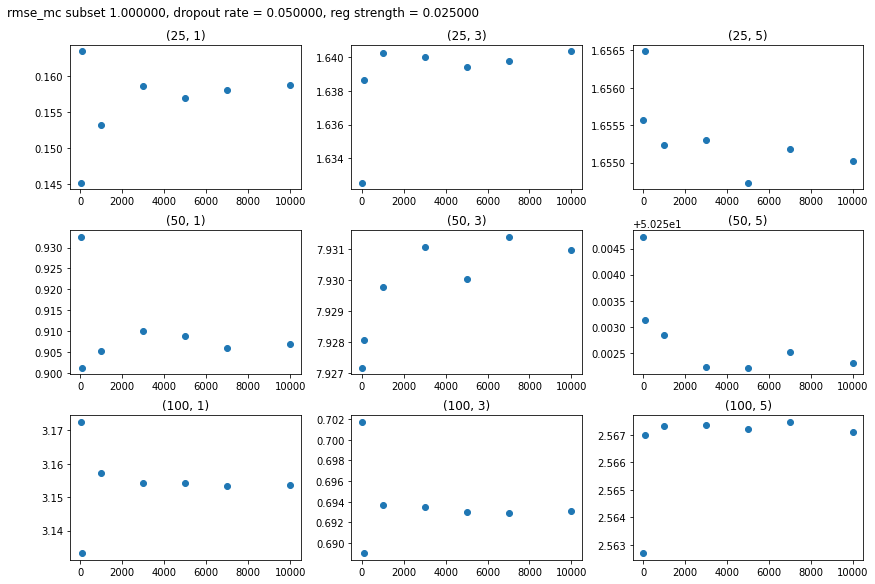

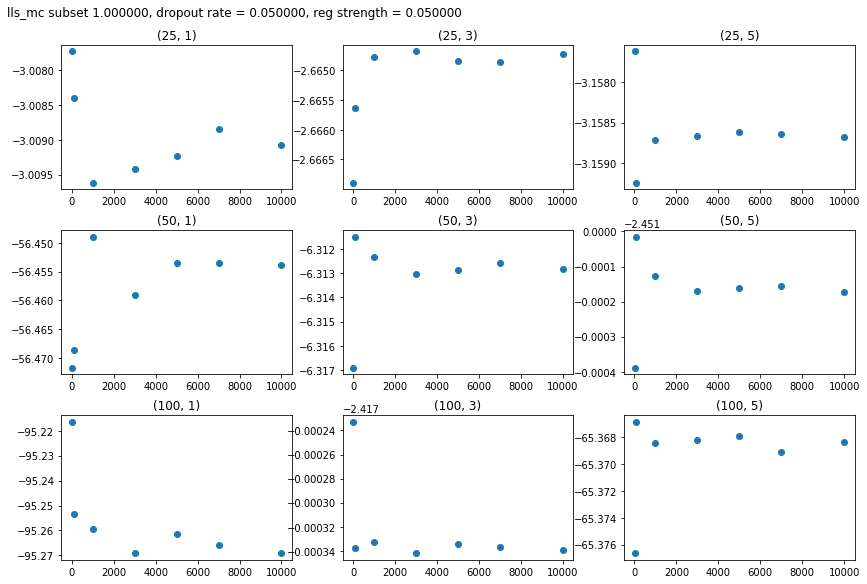

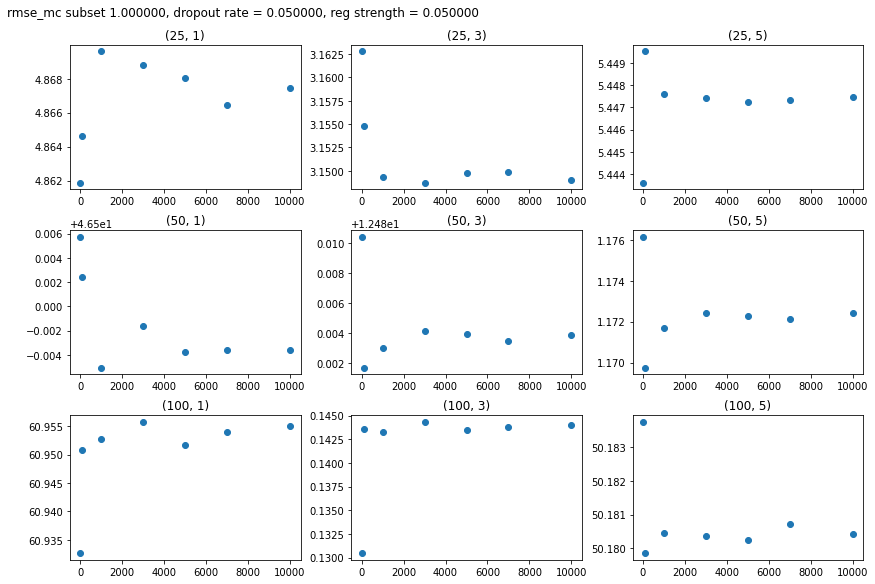

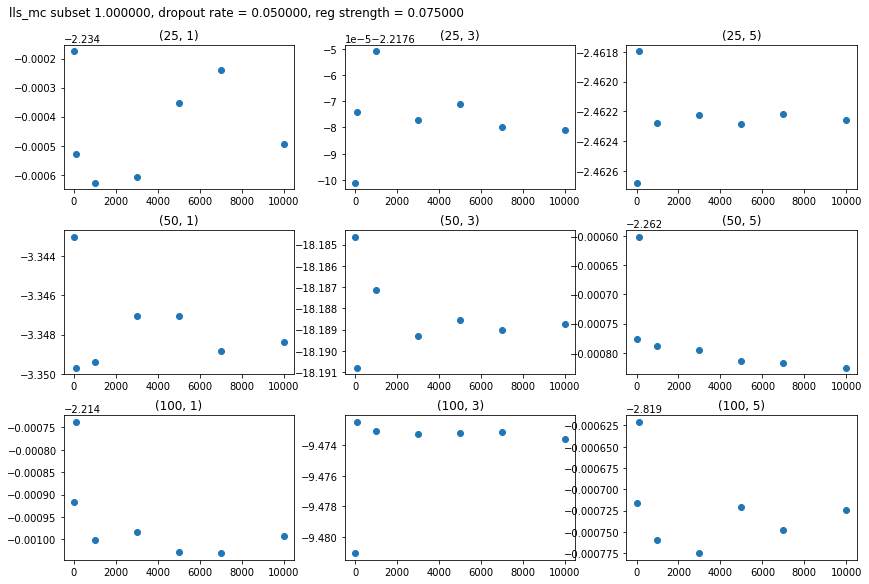

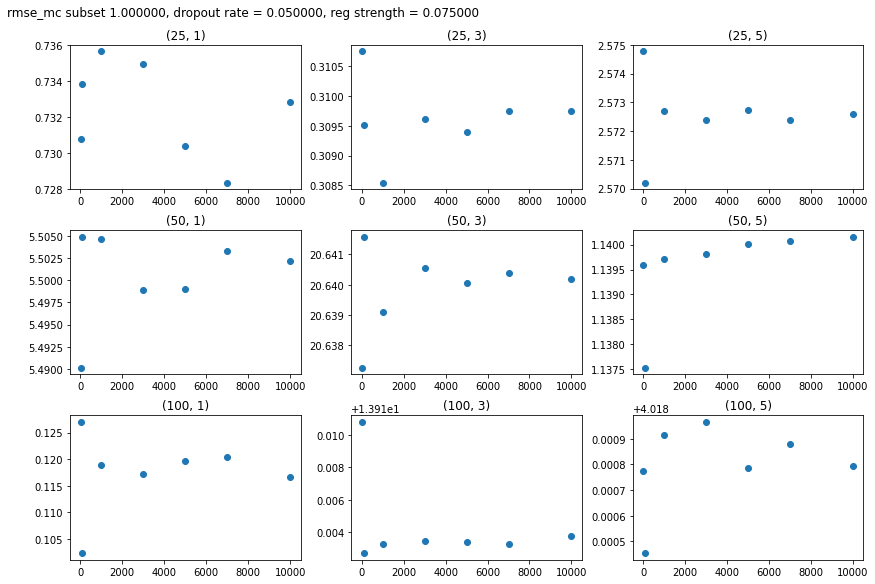

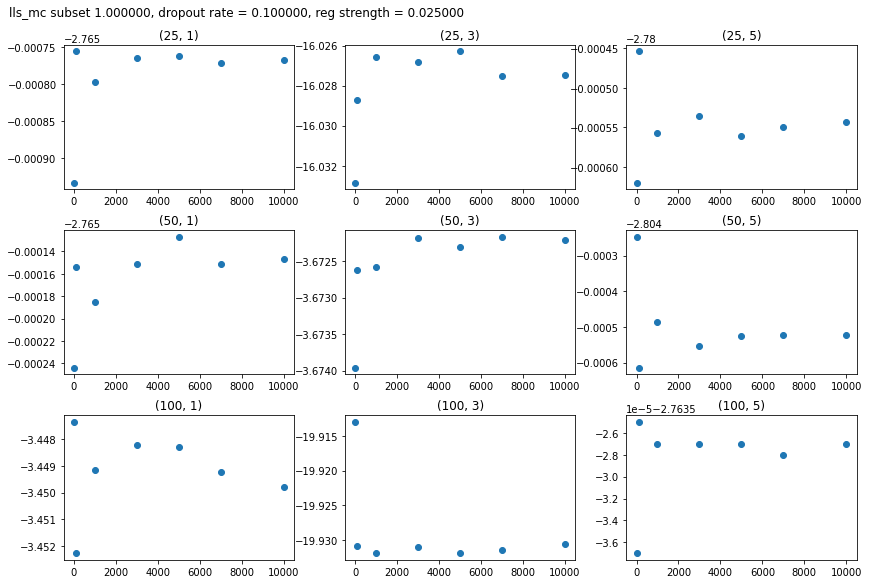

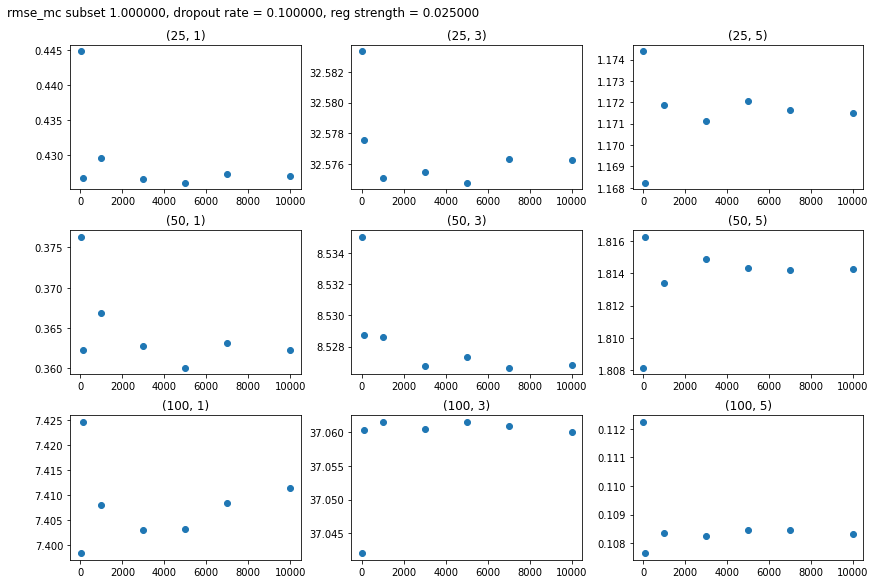

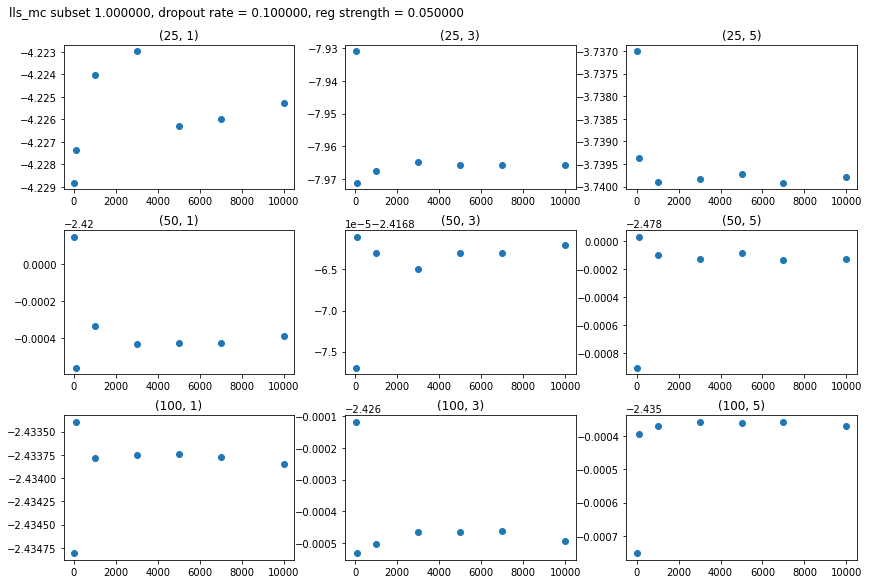

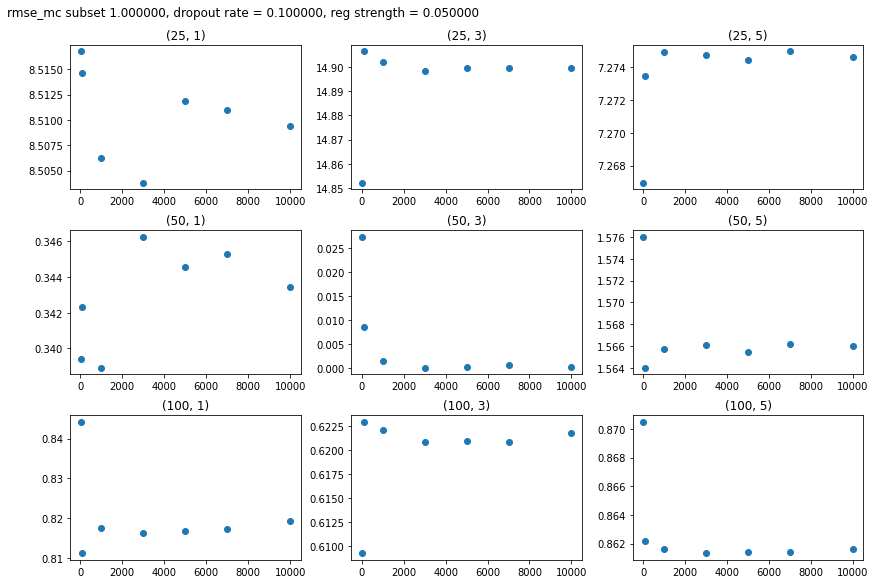

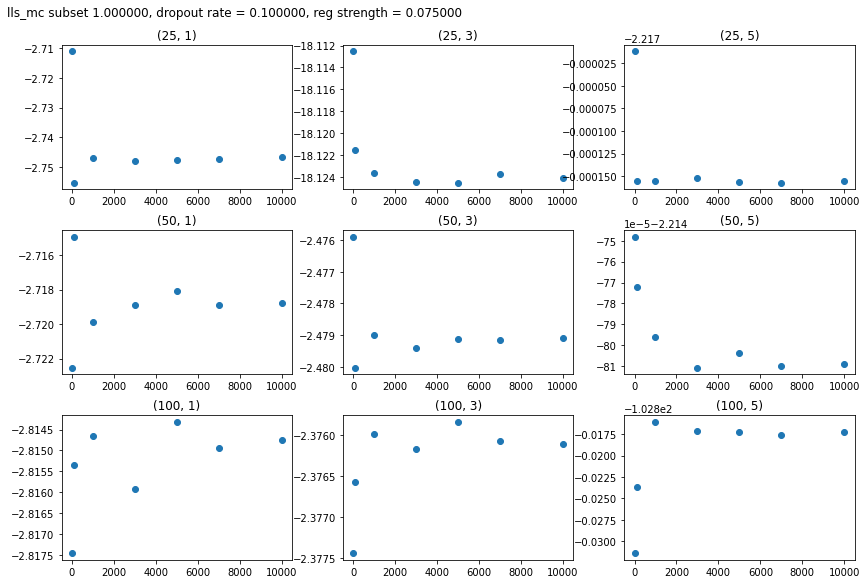

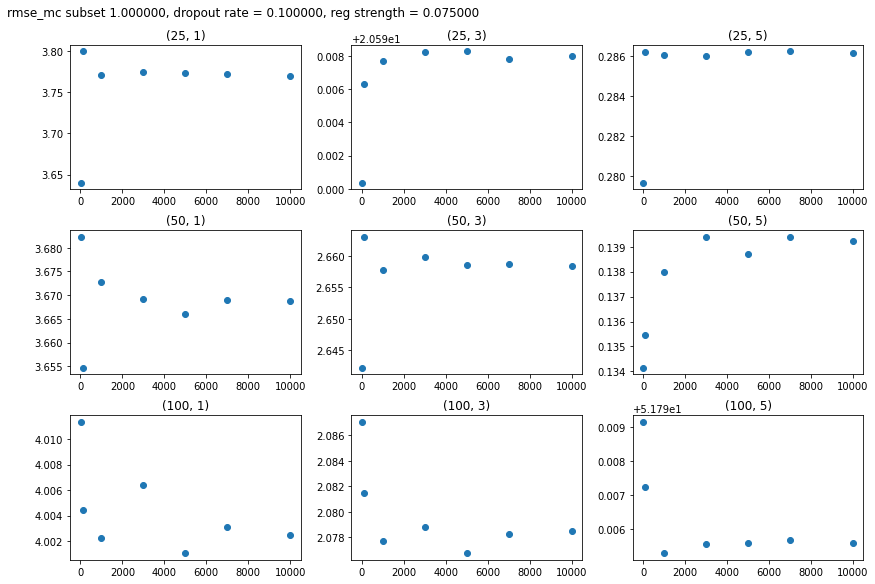

In [7]:
experiment_root_directory = os.path.join(
    './test_results',
    'number_of_test_predictions_1',
    uci_dataset_name,
    test_start_time,
)

for subset_prop, dropout_rate, reg_strength in itertools.product(
    subset_proportions, dropout_rates, reg_strengths,
):
    for metric_name in ['lls_mc', 'rmse_mc']:
        figure_file_name = (
            str(subset_prop)
            + '_' + str(dropout_rate)
            + '_' + str(reg_strength)
            + '_' + metric_name + '.png'
        )
        
        figure_title = (
            metric_name 
            + (' subset %f, dropout rate = %f, reg strength = %f' % (subset_prop, dropout_rate, reg_strength))
        )

        fig, ax = plt.subplots(len(network_hidden_dims), len(network_hidden_layers))

        fig.tight_layout(pad=2, rect=[0, 0.00, 2, 2])    

        plt_subplot_current_row = 0
        
        for hidden_dim in network_hidden_dims:
            plt_subplot_current_column = 0

            for n_layer in network_hidden_layers:
                # Open the score file
                score_file_path = os.path.join(
                    experiment_root_directory,
                    (
                        str(subset_prop) 
                        + '_' + str(hidden_dim)
                        + '_' + str(n_layer) 
                        + '_' + str(dropout_rate) 
                        + '_' + str(reg_strength)
                    ),
                    metric_name + '.txt',
                )

                scores = np.loadtxt(score_file_path).T

                ax[plt_subplot_current_row, plt_subplot_current_column].scatter(scores[0], scores[1])

                ax[plt_subplot_current_row, plt_subplot_current_column].set_title(str((hidden_dim, n_layer)))

                plt_subplot_current_column += 1

            plt_subplot_current_row += 1

        fig.suptitle(figure_title, y=2.05)
        
        plt.savefig(
            os.path.join(experiment_root_directory, figure_file_name),
            dpi=600,
            bbox_inches='tight',
        )
        
        plt.show()